# Code writer: s2264670, s2277042

# ASR Assignment 2021-22

This notebook has been provided as a template to get you started on the assignment.  Feel free to use it for your development, or do your development directly in Python.

You can find a full description of the assignment [here](http://www.inf.ed.ac.uk/teaching/courses/asr/2021-22/coursework.pdf).

You are provided with two Python modules `observation_model.py` and `wer.py`.  The first was described in [Lab 3](https://github.com/ZhaoZeyu1995/asr_labs/blob/master/asr_lab3_4.ipynb).  The second can be used to compute the number of substitution, deletion and insertion errors between ASR output and a reference text.

It can be used as follows:

```python
import wer

my_refence = 'A B C'
my_output = 'A C C D'

wer.compute_alignment_errors(my_reference, my_output)
```

This produces a tuple $(s,d,i)$ giving counts of substitution,
deletion and insertion errors respectively - in this example (1, 0, 1).  The function accepts either two strings, as in the example above, or two lists.  Matching is case sensitive.

## Template code

Assuming that you have already made a function to generate an WFST, `create_wfst()` and a decoder class, `MyViterbiDecoder`, you can perform recognition on all the audio files as follows:


### Import Library

In [10]:
import glob
import os
import wer
import observation_model
import openfst_python as fst
import math
import numpy as np
import time
import pandas as pd
import heapq

In [11]:
# configurations
class CFG:
    DEBUG = False
    if DEBUG:
        sample_num = 2
        verbose = True
    else:
        sample_num = None
        verbose = False
    
    audio_path = '/group/teaching/asr/labs/recordings/*.wav'

### Generate State Table, Phone Table, Word Table from the Lexicon

In [12]:
def parse_lexicon(lex_file):
    """
    Parse the lexicon file and return it in dictionary form.
    
    Args:
        lex_file (str): filename of lexicon file with structure '<word> <phone1> <phone2>...'
                        eg. peppers p eh p er z

    Returns:
        lex (dict): dictionary mapping words to list of phones
    """
    
    lex = {}  # create a dictionary for the lexicon entries (this could be a problem with larger lexica)
    with open(lex_file, 'r') as f:
        for line in f:
            line = line.split()  # split at each space
            lex[line[0]] = line[1:]  # first field the word, the rest is the phones
    return lex




def generate_symbol_tables(lexicon, n=3):
    '''
    Return word, phone and state symbol tables based on the supplied lexicon
    
    Args:
        lexicon (dict): lexicon to use, created from the parse_lexicon() function
        n (int): number of states for each phone HMM
        
    Returns:
        word_table (fst.SymbolTable): table of words
        phone_table (fst.SymbolTable): table of phones
        state_table (fst.SymbolTable): table of HMM phone-state IDs
    '''
    state_table = fst.SymbolTable()
    phone_table = fst.SymbolTable()
    word_table = fst.SymbolTable()
    
    # add empty <eps> symbol to all tables
    state_table.add_symbol('<eps>')
    phone_table.add_symbol('<eps>')
    word_table.add_symbol('<eps>')
    
    for word, phones  in lexicon.items():
        
        word_table.add_symbol(word)
        
        for p in phones: # for each phone
            
            phone_table.add_symbol(p)
            for i in range(1,n+1): # for each state 1 to n
                state_table.add_symbol('{}_{}'.format(p, i))

    return word_table, phone_table, state_table




lex = parse_lexicon('lexicon.txt')
word_table, phone_table, state_table = generate_symbol_tables(lex)

### Baseline wfst (my lab1 solution) (+probability hyperparameter option)

In [13]:
class BaselineWfst:
    
    def __init__(self, n=3, lex=lex, self_loop_prob=None, final_prob_dict=None, uni_prob_dict=None):
        """
        Generate a HMM to recognise any single word sequence for words in the lexicon

        Args:
            n (int): states per phone HMM
            lex: lexicon
            self_loop_prob: hyperparameter
            final_prob_dict: hyperparameter dictionary
            uni_prob_dict: hyperparameter dictionary

        Returns:
            class storing the constructed WFST

        """
        
        self.n = n
        self.lex = lex
        self.final_prob_dict = final_prob_dict
        self.self_loop_prob = self_loop_prob
        self.uni_prob_dict = uni_prob_dict
        self.f = self.generate_wfst()
    
        
    
    def generate_weighted_phone_wfst(self, f, start_state, phone, n, olabel):
        """
        Generate a weighted WFST representing an n-state left-to-right phone HMM.
        Internal function for creating word wfst

        Args:
            f (fst.Fst()): an FST object, assumed to exist already
            start_state (int): the index of the first state, assumed to exist already
            phone (str): the phone label 
            n (int): number of states of the HMM excluding start and end

        Returns:
            the final state of the FST
        """
    

        current_state = start_state

        for i in range(1, n+1):
            if i == n:
                out = olabel
            else:
                out = 0

            in_label = state_table.find('{}_{}'.format(phone, i))

            prev_state = current_state
            current_state = f.add_state()
            if self.self_loop_prob == None:
                f.add_arc(prev_state, fst.Arc(in_label, 0, None, prev_state))
                f.add_arc(prev_state, fst.Arc(in_label, out, None, current_state))
            else:
                f.add_arc(prev_state, fst.Arc(in_label, 0, -math.log(self.self_loop_prob), prev_state))
                f.add_arc(prev_state, fst.Arc(in_label, out, -math.log(1-self.self_loop_prob), current_state))
        
        return current_state
    
    
    def generate_wfst(self):
        """
        """
        
        f = fst.Fst()

        # create a single start state
        start_state = f.add_state()
        f.set_start(start_state)

        for word, phones in self.lex.items():
            current_state = f.add_state()
            if self.uni_prob_dict == None:
                f.add_arc(start_state, fst.Arc(0, 0, None, current_state))
            else:
                f.add_arc(start_state, fst.Arc(0, 0, -math.log(self.uni_prob_dict[word]), current_state))
            for idx,phone in enumerate(phones):
                if idx == len(phones)-1:
                    olabel = word_table.find(word)
                    current_state = self.generate_weighted_phone_wfst(f, current_state, phone, self.n, olabel)
                else:
                    current_state = self.generate_weighted_phone_wfst(f, current_state, phone, self.n, 0)
            # note: new current_state is now set to the final state of the previous phone WFST
            if self.final_prob_dict == None:
                f.set_final(current_state)
            else:
                f.set_final(current_state, -math.log(self.final_prob_dict[word]))
            f.add_arc(current_state, fst.Arc(0, 0, 0, start_state))
        
        f.set_input_symbols(state_table)
        f.set_output_symbols(word_table)
        
        return f

    
    def plot(self):
        """
        """
    
        # We need special code to display the higher-resolution WFSTs inside Jupyter notebook
        from subprocess import check_call
        from IPython.display import Image    
        self.f.draw('tmp.dot', portrait=True)
        check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
        return Image(filename='tmp.png')
    

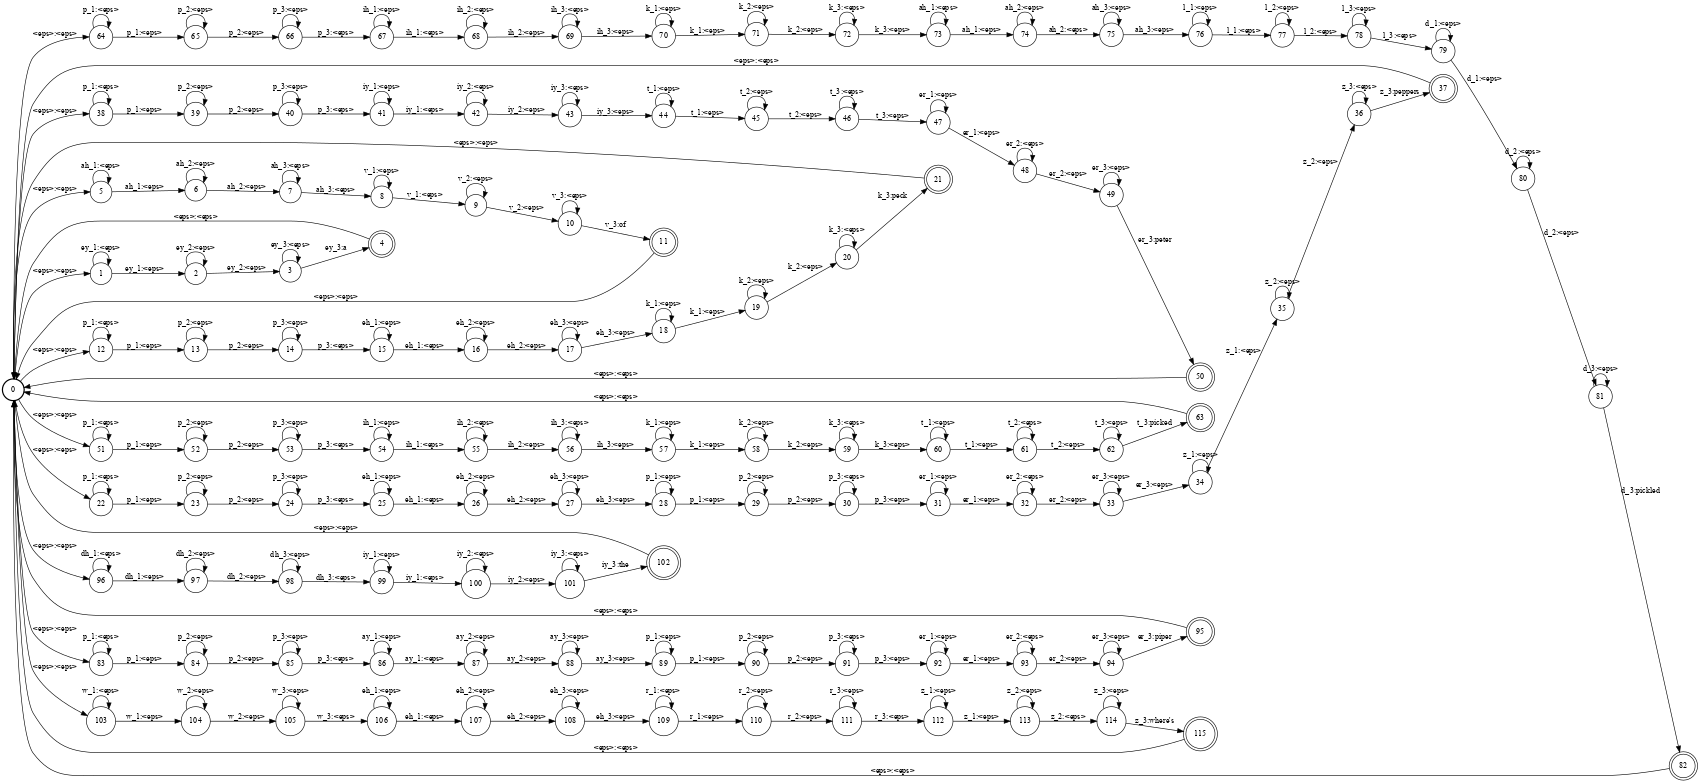

In [14]:
BaselineWfst().plot()

### Baseline Viterbi Decoder (lab3_4 solution)

In [15]:
class BaselineViterbiDecoder:
    
    NLL_ZERO = 1e10  # define a constant representing -log(0).  This is really infinite, but approximate
                     # it here with a very large number
    
    def __init__(self, f = None, audio_file_name = None):
        """Set up the decoder class with an audio file and WFST f
        """
        self.om = observation_model.ObservationModel()
        self.f = f
        self.audio_file_name = audio_file_name
        
        
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        # dynamic loading
        if self.audio_file_name:
            self.om.load_audio(self.audio_file_name)
        else:
            self.om.load_dummy_audio()
    
    
        self.forward_cnt = 0

        
        self.V = []   # stores likelihood along best path reaching state j
        self.B = []   # stores identity of best previous state reaching state j
        self.W = []   # stores output labels sequence along arc reaching j - this removes need for 
                      # extra code to read the output sequence along the best path
        
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
            self.B.append([-1]*self.f.num_states())
            self.W.append([[] for i in range(self.f.num_states())])  #  multiplying the empty list doesn't make multiple
        
        # The above code means that self.V[t][j] for t = 0, ... T gives the Viterbi cost
        # of state j, time t (in negative log-likelihood form)
        # Initialising the costs to NLL_ZERO effectively means zero probability    
        
        # give the WFST start state a probability of 1.0   (NLL = 0.0)
        self.V[0][self.f.start()] = 0.0
        
        # some WFSTs might have arcs with epsilon on the input (you might have already created 
        # examples of these in earlier labs) these correspond to non-emitting states, 
        # which means that we need to process them without stepping forward in time.  
        # Don't worry too much about this!  
        self.traverse_epsilon_arcs(0)        
        
    def traverse_epsilon_arcs(self, t):
        """Traverse arcs with <eps> on the input at time t
        
        These correspond to transitions that don't emit an observation
        
        We've implemented this function for you as it's slightly trickier than
        the normal case.  You might like to look at it to see what's going on, but
        don't worry if you can't fully follow it.
        
        """
        
        states_to_traverse = list(self.f.states()) # traverse all states
        while states_to_traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            i = states_to_traverse.pop(0)   
        
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t][i] + float(arc.weight)
                        
                        # save backtrace information.  In the case of an epsilon transition, 
                        # we save the identity of the best state at t-1.  This means we may not
                        # be able to fully recover the best path, but to do otherwise would
                        # require a more complicated way of storing backtrace information
                        self.B[t][j] = self.B[t][i] 
                        
                        # and save the output labels encountered - this is a list, because
                        # there could be multiple output labels (in the case of <eps> arcs)
                        if arc.olabel != 0:
                            self.W[t][j] = self.W[t][i] + [arc.olabel]
                        else:
                            self.W[t][j] = self.W[t][i]
                        
                        if j not in states_to_traverse:
                            states_to_traverse.append(j)

    
    def forward_step(self, t):
            
        for i in self.f.states():

            if not self.V[t-1][i] == self.NLL_ZERO:   # no point in propagating states with zero probability
                
                for arc in self.f.arcs(i):
                    
                    if arc.ilabel != 0: # <eps> transitions don't emit an observation
                        j = arc.nextstate
                        tp = float(arc.weight)  # transition prob
                        ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
                        prob = tp + ep + self.V[t-1][i] # they're logs
                        
                        self.forward_cnt += 1
                        
                        if prob < self.V[t][j]:
                            self.V[t][j] = prob
                            self.B[t][j] = i
                            
                            # store the output labels encountered too
                            if arc.olabel !=0:
                                self.W[t][j] = [arc.olabel]
                            else:
                                self.W[t][j] = []
                            
    
    def finalise_decoding(self):
        """ this incorporates the probability of terminating at each state
        """
        
        for state in self.f.states():
            final_weight = float(self.f.final(state))
            if self.V[-1][state] != self.NLL_ZERO:
                if final_weight == math.inf:
                    self.V[-1][state] = self.NLL_ZERO  # effectively says that we can't end in this state
                else:
                    self.V[-1][state] += final_weight
                    
        # get a list of all states where there was a path ending with non-zero probability
        finished = [x for x in self.V[-1] if x < self.NLL_ZERO]
        if not finished:  # if empty
            print("No path got to the end of the observations.")
        
        
    def decode(self):
        self.initialise_decoding()
        t = 1
        while t <= self.om.observation_length():
            self.forward_step(t)
            self.traverse_epsilon_arcs(t)
            t += 1
        self.finalise_decoding()
    
    def backtrace(self):
        
        best_final_state = self.V[-1].index(min(self.V[-1])) # argmin
        best_state_sequence = [best_final_state]
        best_out_sequence = []
        
        t = self.om.observation_length()   # ie T
        j = best_final_state
        
        while t >= 0:
            i = self.B[t][j]
            best_state_sequence.append(i)
            best_out_sequence = self.W[t][j] + best_out_sequence  # computer scientists might like
                                                                                # to make this more efficient!

            # continue the backtrace at state i, time t-1
            j = i  
            t-=1
            
        best_state_sequence.reverse()
        
        # convert the best output sequence from FST integer labels into strings
        best_out_sequence = ' '.join([self.f.output_symbols().find(label) for label in best_out_sequence])
        
        return (best_state_sequence, best_out_sequence)


### ASR class

In [16]:
def read_transcription(wav_file):
    """
    Get the transcription corresponding to wav_file.
    """
    
    transcription_file = os.path.splitext(wav_file)[0] + '.txt'
    
    with open(transcription_file, 'r') as f:
        transcription = f.readline().strip()
    
    return transcription


    
class ASR:
    
    def __init__(self, f, decoder, audio_path, sample_num = None, verbose_all = True, verbose_result = True):
        
        """
        Generate a ASR class with a created f from a wfst and a decoder for all existing audio files that match with the audio path.

        Args:
            f (fst.Fst()): an FST object, assumed to exist already
            decoder (class): the index of the first state, assumed to exist already
            audio_path (str): path of the file or folder
            sample_num (int): number of the samples that will be executed from the start of the list at the audio path.
            verbose_all (bool): print result for all audio files
            verbose_result (bool): print the final averaged result

        """
        self.f = f
        self.decoder = decoder
        self.audio_path = audio_path
        self.sample_num = sample_num
        self.verbose_all = verbose_all
        self.verbose_result = verbose_result
        
        self.run()
    
    
    def run(self):
        """
        """
        
        
        records = []
        
        self.decoder.f = self.f
        
        # run for each .wav file
        for idx,wav_file in enumerate(glob.glob(self.audio_path)):    # replace path if using your own
                                                                       # audio files
            # end
            if self.sample_num and idx >= self.sample_num: break
                
            # set decoder argument
            self.decoder.audio_file_name = wav_file

            # measure decoding time
            start_time = time.time()
            self.decoder.decode()
            decode_time = time.time() - start_time
            
            # measure backtracing time
            start_time = time.time()
            (state_path, words) = self.decoder.backtrace()
            backtrace_time = time.time() - start_time
            
            # measure forward function counts in the decoding process
            forward_cnt = self.decoder.forward_cnt

            
            # measure WER accuracy
            transcription = read_transcription(wav_file)
            (sub_cnt, del_cnt, ins_cnt) = wer.compute_alignment_errors(transcription, words)
            word_cnt = len(transcription.split())
            accuracy = sum([sub_cnt, del_cnt, ins_cnt])/word_cnt
            
            
            # print results for each .wav file
            if self.verbose_all:
                print(wav_file)
                print('Transcription: ' + transcription)
                print('Prediction: ' + words)
                print('Substiution: {}, Deletion: {}, Insertion: {}, Number of words: {}, Accuracy: {:.3f}'
                      .format(sub_cnt, del_cnt, ins_cnt, word_cnt, accuracy))
                print('Forward: {}'.format(forward_cnt))
                print()
            
            
            # save the measurements
            records.append([sub_cnt, del_cnt, ins_cnt, word_cnt, accuracy, decode_time, backtrace_time, forward_cnt])
        
        
        
        # average measurements
        self.sub_cnt, self.del_cnt, self.ins_cnt, self.word_cnt, self.accuracy, self.decode_time, self.backtrace_time, self.forward_cnt = np.average(records, axis=0)
        
        
        # f related measurements
        num_arcs = 0
        for state in self.f.states():
            num_arcs += self.f.num_arcs(state)
        self.num_arcs = num_arcs
        self.num_states = self.f.num_states()
        
        
        # print results
        if self.verbose_result:
            print("====================Result from {} samples==================".format(idx))
            self.print_all()
        
        
        
        
    def print_accuracy(self):
        """
        """
        print('-- Accuracy Info  *All Average Values* '.ljust(100, '-')) 
        print('| Substiution: {:.3f}, Deletion: {:.3f}, Insertion: {:.3f}, Number of words: {:.3f}, Accuracy: {:.3f}'
              .format(self.sub_cnt, self.del_cnt, self.ins_cnt, self.word_cnt, self.accuracy)
              .ljust(99,' ')+'|')
        print(''.ljust(100, '-'))
        
        
    def print_speed(self):
        """
        """
        print('-- Speed Info  *All Average Values* '.ljust(100, '-'))
        print('| Decoding time: {:.3f}s, Backtracing time: {:.3f}s, Number of forward computations: {:.3f}'
              .format(self.decode_time, self.backtrace_time, self.forward_cnt)
              .ljust(99,' ')+'|')
        print(''.ljust(100, '-'))
    
    
    def print_memory(self):
        """
        """
        print('-- Memory Info '.ljust(100, '-'))
        print('| Number of states: {}, Number of arcs: {}'
              .format(self.num_states, self.num_arcs)
              .ljust(99,' ')+'|')
        print(''.ljust(100, '-'))

        
    def print_all(self):
        """
        """
        self.print_accuracy()
        self.print_speed()
        self.print_memory()
        print()
        

## Task 1 -Baseline-

In [8]:
# create WFST and decoder
f = BaselineWfst().f
decoder = BaselineViterbiDecoder()

# create ASR
asr = ASR(f, decoder, CFG.audio_path, CFG.sample_num, verbose_all = CFG.verbose, verbose_result = CFG.verbose)

# save result in a dataframe
result_df_1 = pd.DataFrame(columns=["self-prob", "accuracy","num_arcs",
                                      "num_states","decode_time", "backtrace_time", "forward_cnt"])
tmp = pd.Series([None, asr.accuracy, asr.num_arcs, asr.num_states, 
                     asr.decode_time, asr.backtrace_time, asr.forward_cnt], index=result_df_1.columns, name=0)
result_df_1 = result_df_1.append(tmp)
if CFG.DEBUG == False:
    result_df_1.to_csv("task_1_baseline_df.csv",index=False)
result_df_1

/group/teaching/asr/labs/recordings/0000.wav
Transcription: of of a peter the piper the pickled
Prediction: the a of a of of peter the a of picked a peppers the the picked the
Substiution: 3, Deletion: 0, Insertion: 9, Number of words: 8, Accuracy: 1.500
Forward: 113478

/group/teaching/asr/labs/recordings/0001.wav
Transcription: piper peck peppers peter peter picked pickled peck peter piper
Prediction: the a the of a peppers peter peter picked picked pickled peck the peter piper the
Substiution: 2, Deletion: 0, Insertion: 6, Number of words: 10, Accuracy: 0.800
Forward: 214908

/group/teaching/asr/labs/recordings/0002.wav
Transcription: peck of peck pickled pickled picked piper peck picked a
Prediction: the a pickled a peck pickled pickled picked the piper peck picked pickled the picked
Substiution: 3, Deletion: 0, Insertion: 5, Number of words: 10, Accuracy: 0.800
Forward: 166188

/group/teaching/asr/labs/recordings/0003.wav
Transcription: peck pickled piper piper piper peter a a pip

/group/teaching/asr/labs/recordings/0030.wav
Transcription: peter piper picked a peck of pickled peppers
Prediction: the peter piper picked of peck of pickled peppers the
Substiution: 1, Deletion: 0, Insertion: 2, Number of words: 8, Accuracy: 0.375
Forward: 91638

/group/teaching/asr/labs/recordings/0031.wav
Transcription: pickled peppers where's the peck of pickled peppers
Prediction: the pickled peppers where's the peck of pickled peck where's the
Substiution: 1, Deletion: 0, Insertion: 3, Number of words: 8, Accuracy: 0.500
Forward: 71898

/group/teaching/asr/labs/recordings/0032.wav
Transcription: where's the peck of pickled peppers peter piper picked
Prediction: the where's the peck of pickled peck where's peter picked picked the
Substiution: 2, Deletion: 0, Insertion: 3, Number of words: 9, Accuracy: 0.556
Forward: 79038

/group/teaching/asr/labs/recordings/0033.wav
Transcription: peter piper picked
Prediction: the peter piper of picked
Substiution: 0, Deletion: 0, Insertion: 2,

/group/teaching/asr/labs/recordings/0060.wav
Transcription: piper peter picked a peck
Prediction: the pickled the of of a the of of of peck the
Substiution: 3, Deletion: 0, Insertion: 7, Number of words: 5, Accuracy: 2.000
Forward: 73578

/group/teaching/asr/labs/recordings/0061.wav
Transcription: piper picked
Prediction: the peck the of of picked the
Substiution: 1, Deletion: 0, Insertion: 5, Number of words: 2, Accuracy: 3.000
Forward: 52158

/group/teaching/asr/labs/recordings/0062.wav
Transcription: peck peppers peter
Prediction: the pickled of of of of the the of the
Substiution: 3, Deletion: 0, Insertion: 7, Number of words: 3, Accuracy: 3.333
Forward: 73578

/group/teaching/asr/labs/recordings/0063.wav
Transcription: peter piper picked a pickled peter
Prediction: the a the of of of picked the picked of a the the
Substiution: 4, Deletion: 0, Insertion: 7, Number of words: 6, Accuracy: 1.833
Forward: 89748

/group/teaching/asr/labs/recordings/0064.wav
Transcription: piper peter pi

/group/teaching/asr/labs/recordings/0093.wav
Transcription: peter piper where's
Prediction: the peter piper where's the
Substiution: 0, Deletion: 0, Insertion: 2, Number of words: 3, Accuracy: 0.667
Forward: 82188

/group/teaching/asr/labs/recordings/0094.wav
Transcription: peck of pickled peppers
Prediction: peck the peck pickled pickled peppers the
Substiution: 1, Deletion: 0, Insertion: 3, Number of words: 4, Accuracy: 1.000
Forward: 103818

/group/teaching/asr/labs/recordings/0095.wav
Transcription: peter piper picked a peck of pickled peppers
Prediction: the picked picked peter picked of peck pickled of where's the
Substiution: 5, Deletion: 0, Insertion: 3, Number of words: 8, Accuracy: 1.000
Forward: 98778

/group/teaching/asr/labs/recordings/0096.wav
Transcription: peter picked a peck
Prediction: peck peter picked peck peck the
Substiution: 1, Deletion: 0, Insertion: 2, Number of words: 4, Accuracy: 0.750
Forward: 52158

/group/teaching/asr/labs/recordings/0097.wav
Transcription

/group/teaching/asr/labs/recordings/0121.wav
Transcription: peppers picked peck peter pickled picked peter piper the of peck a peppers where's of pickled piper
Prediction: the peppers a where's picked the the of picked pickled picked peter of picked pickled the peck of peppers where's of the pickled picked picked the
Substiution: 7, Deletion: 0, Insertion: 9, Number of words: 17, Accuracy: 0.941
Forward: 316338

/group/teaching/asr/labs/recordings/0122.wav
Transcription: peter picked pickled peppers
Prediction: the peck the picked picked pickled peck where's the
Substiution: 2, Deletion: 0, Insertion: 5, Number of words: 4, Accuracy: 1.750
Forward: 95208

/group/teaching/asr/labs/recordings/0123.wav
Transcription: picked peter peter the where's pickled peck picked piper peppers a peppers of pickled peck piper of
Prediction: the picked the of peter the where's pickled peck a picked pickled picked of peck the peppers of peck where's of the pickled the peck the picked of where's the
Subst

/group/teaching/asr/labs/recordings/0149.wav
Transcription: where's peter piper
Prediction: the where's the the of piper the
Substiution: 1, Deletion: 0, Insertion: 4, Number of words: 3, Accuracy: 1.667
Forward: 97938

/group/teaching/asr/labs/recordings/0150.wav
Transcription: peter piper picked peppers
Prediction: the of the pickled a picked the of where's the
Substiution: 3, Deletion: 0, Insertion: 6, Number of words: 4, Accuracy: 2.250
Forward: 107598

/group/teaching/asr/labs/recordings/0151.wav
Transcription: the pickled peppers peter piper picked
Prediction: peck the of pickled peppers peter of piper of peter the
Substiution: 1, Deletion: 0, Insertion: 5, Number of words: 6, Accuracy: 1.000
Forward: 97938

/group/teaching/asr/labs/recordings/0152.wav
Transcription: a peck of pickled peppers
Prediction: picked the of peck of pickled peppers the
Substiution: 1, Deletion: 0, Insertion: 3, Number of words: 5, Accuracy: 0.800
Forward: 84288

/group/teaching/asr/labs/recordings/0153.

/group/teaching/asr/labs/recordings/0182.wav
Transcription: peter pickled peppers
Prediction: the peter pickled peppers the
Substiution: 0, Deletion: 0, Insertion: 2, Number of words: 3, Accuracy: 0.667
Forward: 56148

/group/teaching/asr/labs/recordings/0183.wav
Transcription: peppers of a where's picked
Prediction: the peck where's of where's picked the
Substiution: 3, Deletion: 0, Insertion: 2, Number of words: 5, Accuracy: 1.000
Forward: 52998

/group/teaching/asr/labs/recordings/0184.wav
Transcription: piper the where's a pickled peck of picked
Prediction: the piper of of where's of pickled peck of picked the
Substiution: 2, Deletion: 0, Insertion: 3, Number of words: 8, Accuracy: 0.625
Forward: 90168

/group/teaching/asr/labs/recordings/0185.wav
Transcription: piper the peck peter pickled where's peppers of a pickled
Prediction: the piper of peck peter pickled where's peck where's of the pickled the
Substiution: 3, Deletion: 0, Insertion: 3, Number of words: 10, Accuracy: 0.600
F

/group/teaching/asr/labs/recordings/0215.wav
Transcription: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
Prediction: the peter piper of peter of a picked of pickled peppers where's the pickled pickled peppers peter piper peter the
Substiution: 4, Deletion: 1, Insertion: 4, Number of words: 17, Accuracy: 0.529
Forward: 186558

/group/teaching/asr/labs/recordings/0216.wav
Transcription: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
Prediction: the of piper pickled pickled piper pickled peppers where's of pickled pickled peppers peter piper peter the
Substiution: 5, Deletion: 3, Insertion: 3, Number of words: 17, Accuracy: 0.647
Forward: 197268

/group/teaching/asr/labs/recordings/0217.wav
Transcription: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
Prediction: peck the the piper picked of pickled pickled peppers where's of pick

/group/teaching/asr/labs/recordings/0245.wav
Transcription: peter piper picked a peck of pickled peppers
Prediction: peck the peter piper picked picked of pickled peppers the
Substiution: 1, Deletion: 1, Insertion: 3, Number of words: 8, Accuracy: 0.625
Forward: 86178

/group/teaching/asr/labs/recordings/0246.wav
Transcription: the peck of pickled peppers
Prediction: the peck of pickled peppers the
Substiution: 0, Deletion: 0, Insertion: 1, Number of words: 5, Accuracy: 0.200
Forward: 64758

/group/teaching/asr/labs/recordings/0247.wav
Transcription: a peck of pickled peppers
Prediction: the peck of pickled peppers the
Substiution: 1, Deletion: 0, Insertion: 1, Number of words: 5, Accuracy: 0.400
Forward: 58878

/group/teaching/asr/labs/recordings/0248.wav
Transcription: peter piper picked a peck of pickled peppers
Prediction: the peck a picked piper of picked peck of picked where's the
Substiution: 5, Deletion: 0, Insertion: 4, Number of words: 8, Accuracy: 1.125
Forward: 96888

/grou

/group/teaching/asr/labs/recordings/0274.wav
Transcription: pickled peppers where's the peck
Prediction: the picked of peppers where's the peck the
Substiution: 1, Deletion: 0, Insertion: 3, Number of words: 5, Accuracy: 0.800
Forward: 80928

/group/teaching/asr/labs/recordings/0275.wav
Transcription: peter piper picked
Prediction: a the peter piper picked the
Substiution: 0, Deletion: 0, Insertion: 3, Number of words: 3, Accuracy: 1.000
Forward: 82608

/group/teaching/asr/labs/recordings/0276.wav
Transcription: peter peter peter peter picked
Prediction: the peter peter peter peter picked the
Substiution: 0, Deletion: 0, Insertion: 2, Number of words: 5, Accuracy: 0.400
Forward: 70008

/group/teaching/asr/labs/recordings/0277.wav
Transcription: peck picked peter pickled peck
Prediction: the peck picked peter pickled peck picked
Substiution: 0, Deletion: 0, Insertion: 2, Number of words: 5, Accuracy: 0.400
Forward: 57618

/group/teaching/asr/labs/recordings/0278.wav
Transcription: peter

/group/teaching/asr/labs/recordings/0303.wav
Transcription: where's a peck of pickled peter
Prediction: the where's of peck of pickled peter a the
Substiution: 1, Deletion: 0, Insertion: 3, Number of words: 6, Accuracy: 0.667
Forward: 59298

/group/teaching/asr/labs/recordings/0304.wav
Transcription: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
Prediction: the the of a where's of picked the a where's picked picked where's the where's the picked of picked where's a of piper a peter the
Substiution: 11, Deletion: 0, Insertion: 9, Number of words: 17, Accuracy: 1.176
Forward: 202728

/group/teaching/asr/labs/recordings/0305.wav
Transcription: peter piper pickled a peck of picked peppers where's the peck of pickled peppers peter piper picked
Prediction: the picked piper picked a of peck of the picked where's the a the peck of pickled picked where's the peck pickled picked the
Substiution: 5, Deletion: 1, Insertion: 8, Number of words: 

/group/teaching/asr/labs/recordings/0331.wav
Transcription: the peck peter peppers peppers peck piper
Prediction: picked the of picked of peppers of picked peck piper picked the
Substiution: 3, Deletion: 0, Insertion: 5, Number of words: 7, Accuracy: 1.143
Forward: 95208

/group/teaching/asr/labs/recordings/0332.wav
Transcription: where's piper of a peter pickled picked of piper peter the pickled
Prediction: peck the where's piper of picked of pickled picked of piper picked the pickled the
Substiution: 3, Deletion: 0, Insertion: 3, Number of words: 12, Accuracy: 0.500
Forward: 122088

/group/teaching/asr/labs/recordings/0333.wav
Transcription: of piper of a peck picked piper peter picked pickled peter
Prediction: the of piper of peck picked piper picked picked pickled peter the
Substiution: 1, Deletion: 1, Insertion: 2, Number of words: 11, Accuracy: 0.364
Forward: 114948

/group/teaching/asr/labs/recordings/0334.wav
Transcription: picked peter peck pickled the piper peter
Prediction: 

,self-prob,accuracy,num_arcs,num_states,decode_time,backtrace_time,forward_cnt
0,NaN,0.887683,230.0,116.0,5.205924,0.001088,106198.985915


## Task 2 -WFST tests-

1~3: Change hyperparameters for BaselineWfst class  
4: Create a new SilenceWfst class

### 1. Self-loop probability

In [9]:
result_df_2_1 = pd.DataFrame(columns=["self-prob", "accuracy","num_arcs",
                                      "num_states","decode_time", "backtrace_time", "forward_cnt"])
for i in range(1, 10):
    prob = i * 0.1
    print("Self loop probability={}".format(prob))
    
    
    # create WFST and decoder
    f = BaselineWfst(self_loop_prob=prob).f
    decoder = BaselineViterbiDecoder()
    
    # create ASR
    asr = ASR(f, decoder, CFG.audio_path, CFG.sample_num, verbose_all = True, verbose_result = True)
    
    # save result in a dataframe
    tmp = pd.Series([prob, asr.accuracy, asr.num_arcs, asr.num_states, 
                     asr.decode_time, asr.backtrace_time, asr.forward_cnt], index=result_df_2_1.columns, name=i)
    result_df_2_1 = result_df_2_1.append(tmp)
    
if CFG.DEBUG == False:
    result_df_2_1.to_csv("task_2_self_loop_df.csv",index=False)
    
result_df_2_1

Self loop probability=0.1
/group/teaching/asr/labs/recordings/0000.wav
Transcription: of of a peter the piper the pickled
Prediction: peck the the a of a of the of peter the peck a a of picked a a piper pickled the the pickled picked the the a
Substiution: 1, Deletion: 0, Insertion: 19, Number of words: 8, Accuracy: 2.500
Forward: 113478

/group/teaching/asr/labs/recordings/0001.wav
Transcription: piper peck peppers peter peter picked pickled peck peter piper
Prediction: peck the the the the the the the the the the a peter of a a peppers a peter peter picked picked pickled peck the the peter picked piper picked the picked the
Substiution: 0, Deletion: 1, Insertion: 24, Number of words: 10, Accuracy: 2.500
Forward: 214908

/group/teaching/asr/labs/recordings/0002.wav
Transcription: peck of peck pickled pickled picked piper peck picked a
Prediction: picked the the the the a pickled a picked pickled pickled picked picked the piper peck picked the picked pickled picked picked picked the th

/group/teaching/asr/labs/recordings/0025.wav
Transcription: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
Prediction: picked the the picked piper of picked of peck of pickled peppers peck the where's of peck of pickled the of where's picked of piper picked picked the the the
Substiution: 5, Deletion: 0, Insertion: 13, Number of words: 17, Accuracy: 1.059
Forward: 145398

/group/teaching/asr/labs/recordings/0026.wav
Transcription: a peck of pickled peppers peter piper picked
Prediction: picked the the the the the the picked pickled pickled picked where's peter of piper picked a a picked picked the the the the the the a
Substiution: 4, Deletion: 0, Insertion: 19, Number of words: 8, Accuracy: 2.875
Forward: 98778

/group/teaching/asr/labs/recordings/0027.wav
Transcription: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
Prediction: picked the the the the of of of picked of a the the 

/group/teaching/asr/labs/recordings/0051.wav
Transcription: the peck of pickled peppers
Prediction: the the the picked the picked picked picked a a a picked of pickled a a a where's picked the the the the picked the
Substiution: 2, Deletion: 0, Insertion: 20, Number of words: 5, Accuracy: 4.400
Forward: 103818

/group/teaching/asr/labs/recordings/0052.wav
Transcription: peter piper peter piper peter piper
Prediction: picked picked picked the picked peter of of piper pickled picked peck peter of piper pickled picked the peter of pickled the the the the the picked the
Substiution: 1, Deletion: 0, Insertion: 22, Number of words: 6, Accuracy: 3.833
Forward: 129018

/group/teaching/asr/labs/recordings/0053.wav
Transcription: peter piper picked
Prediction: picked a the the the the peck peter pickled piper pickled peck picked picked the picked picked peck peck
Substiution: 0, Deletion: 0, Insertion: 16, Number of words: 3, Accuracy: 5.333
Forward: 74418

/group/teaching/asr/labs/recordings/00

/group/teaching/asr/labs/recordings/0078.wav
Transcription: where's the peck of pickled peppers peter piper picked
Prediction: picked the the the where's the peck of picked a the peck where's peter of piper picked picked picked the
Substiution: 2, Deletion: 0, Insertion: 11, Number of words: 9, Accuracy: 1.444
Forward: 88068

/group/teaching/asr/labs/recordings/0079.wav
Transcription: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
Prediction: picked the peter piper of picked of picked of peck pickled peck peppers picked the where's the picked of peck pickled peck picked peter piper the picked picked the picked picked the
Substiution: 4, Deletion: 0, Insertion: 15, Number of words: 17, Accuracy: 1.118
Forward: 173958

/group/teaching/asr/labs/recordings/0080.wav
Transcription: peter piper picked a peck of pickled peppers
Prediction: the the peter of piper picked of peck of pickled peppers picked the the the
Substiution: 1, Deletion: 0

/group/teaching/asr/labs/recordings/0106.wav
Transcription: where's piper peter picked a peck of pickled peppers where's peter
Prediction: picked the the the the piper where's where's the of piper of the picked peter peter of piper pickled of picked pickled peck peppers the where's peter picked picked the the a the the the the picked
Substiution: 3, Deletion: 0, Insertion: 26, Number of words: 11, Accuracy: 2.636
Forward: 199368

/group/teaching/asr/labs/recordings/0107.wav
Transcription: where's the peck of pickled peppers where's the peter pickled peppers
Prediction: picked the the the where's the where's of piper piper of peter pickled peppers the where's the of peter the pickled piper picked picked the the picked picked the the
Substiution: 2, Deletion: 0, Insertion: 19, Number of words: 11, Accuracy: 1.909
Forward: 213018

/group/teaching/asr/labs/recordings/0108.wav
Transcription: peter pickled a peck of the peppers where's the peter pickled
Prediction: picked the the the the the

/group/teaching/asr/labs/recordings/0125.wav
Transcription: picked peck of peter
Prediction: picked the the the the the picked picked peck of peter picked picked the the the picked
Substiution: 0, Deletion: 0, Insertion: 13, Number of words: 4, Accuracy: 3.250
Forward: 78198

/group/teaching/asr/labs/recordings/0126.wav
Transcription: peck where's pickled piper picked the peck
Prediction: picked the the the the picked peck where's pickled piper picked the peck picked the the the the the the the
Substiution: 0, Deletion: 0, Insertion: 14, Number of words: 7, Accuracy: 2.000
Forward: 124818

/group/teaching/asr/labs/recordings/0127.wav
Transcription: piper picked pickled picked where's peter peppers piper peppers
Prediction: picked the the the the the the the the the picked the the piper the of picked pickled picked where's peter of peppers piper peppers picked the the the the the the the a the the the the
Substiution: 0, Deletion: 0, Insertion: 29, Number of words: 9, Accuracy: 3.222
Fo

/group/teaching/asr/labs/recordings/0149.wav
Transcription: where's peter piper
Prediction: picked the the the the the picked the the picked where's the the of of piper picked the the the the the the the the the picked
Substiution: 1, Deletion: 0, Insertion: 24, Number of words: 3, Accuracy: 8.333
Forward: 97938

/group/teaching/asr/labs/recordings/0150.wav
Transcription: peter piper picked peppers
Prediction: picked the picked the the of the pickled a a picked the of where's picked the the the the the the picked the
Substiution: 3, Deletion: 0, Insertion: 19, Number of words: 4, Accuracy: 5.500
Forward: 107598

/group/teaching/asr/labs/recordings/0151.wav
Transcription: the pickled peppers peter piper picked
Prediction: picked the the the the the of pickled the peppers peter of piper of peter a the the the the the
Substiution: 1, Deletion: 0, Insertion: 15, Number of words: 6, Accuracy: 2.667
Forward: 97938

/group/teaching/asr/labs/recordings/0152.wav
Transcription: a peck of pickled

/group/teaching/asr/labs/recordings/0177.wav
Transcription: peter picked a peck of peppers
Prediction: picked the the the picked picked of peck peck peppers the the the picked
Substiution: 3, Deletion: 0, Insertion: 8, Number of words: 6, Accuracy: 1.833
Forward: 70008

/group/teaching/asr/labs/recordings/0178.wav
Transcription: peter piper picked a peck of pickled peppers
Prediction: picked the the the the the peter piper of picked of where's of pickled peppers picked the the
Substiution: 2, Deletion: 0, Insertion: 10, Number of words: 8, Accuracy: 1.500
Forward: 80928

/group/teaching/asr/labs/recordings/0179.wav
Transcription: peter picked a peck of peppers
Prediction: picked the the the picked peter picked the of a a of of peppers the the the the
Substiution: 1, Deletion: 0, Insertion: 12, Number of words: 6, Accuracy: 2.167
Forward: 81768

/group/teaching/asr/labs/recordings/0180.wav
Transcription: where's the peck of pickled peppers peter piper picked
Prediction: the the the the 

/group/teaching/asr/labs/recordings/0206.wav
Transcription: peck of pickled peppers peter piper picked
Prediction: picked the the picked picked peck of pickled peppers peter of peter picked pickled picked the the the the
Substiution: 1, Deletion: 0, Insertion: 12, Number of words: 7, Accuracy: 1.857
Forward: 95208

/group/teaching/asr/labs/recordings/0207.wav
Transcription: peter piper picked a peck
Prediction: the the the the picked the the the picked picked where's piper of picked of peck picked the
Substiution: 2, Deletion: 0, Insertion: 13, Number of words: 5, Accuracy: 3.000
Forward: 84498

/group/teaching/asr/labs/recordings/0208.wav
Transcription: picked a peck of pickled peppers
Prediction: of the the the peppers of peck picked pickled of of pickled peppers picked the picked the the picked
Substiution: 2, Deletion: 0, Insertion: 13, Number of words: 6, Accuracy: 2.500
Forward: 116628

/group/teaching/asr/labs/recordings/0209.wav
Transcription: where's the peck of pickled
Predic

/group/teaching/asr/labs/recordings/0232.wav
Transcription: pickled peter piper peppers picked pickled piper peter
Prediction: picked the the pickled peter piper peck where's picked pickled piper peter picked
Substiution: 1, Deletion: 0, Insertion: 5, Number of words: 8, Accuracy: 0.750
Forward: 82608

/group/teaching/asr/labs/recordings/0233.wav
Transcription: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
Prediction: peck the the the the the the peter piper pickled picked of peck of pickled peck where's the picked where's the of peck of pickled peck where's the the picked of the picked picked the the the the piper
Substiution: 5, Deletion: 0, Insertion: 22, Number of words: 17, Accuracy: 1.588
Forward: 179418

/group/teaching/asr/labs/recordings/0234.wav
Transcription: a peck of pickled peppers peter piper picked
Prediction: picked pickled picked picked of picked of pickled peppers pickled piper of picked picked the the the
Substiu

/group/teaching/asr/labs/recordings/0256.wav
Transcription: peter piper picked of peppers of peppers of peppers peter piper
Prediction: the peter piper the pickled peck the of pickled picked picked picked of peppers where's the of pickled picked peck picked peck peppers the where's piper where's picked piper picked the pickled picked the the the a
Substiution: 3, Deletion: 0, Insertion: 26, Number of words: 11, Accuracy: 2.636
Forward: 236748

/group/teaching/asr/labs/recordings/0257.wav
Transcription: peter piper picked peter piper picked a peck of of peppers peppers peppers piper
Prediction: peck of peter piper picked picked pickled picked picked picked picked peck peppers where's the peck of peck a picked peppers picked the picked peter picked piper picked peck picked picked picked picked picked
Substiution: 6, Deletion: 0, Insertion: 20, Number of words: 14, Accuracy: 1.857
Forward: 215328

/group/teaching/asr/labs/recordings/0258.wav
Transcription: where's the peter piper peck of 

/group/teaching/asr/labs/recordings/0281.wav
Transcription: peter pickled peppers where's the peppers peter pickled
Prediction: picked picked the the pickled peter pickled peppers where's the peppers peter pickled picked the the the the the the the the the
Substiution: 0, Deletion: 0, Insertion: 15, Number of words: 8, Accuracy: 1.875
Forward: 109488

/group/teaching/asr/labs/recordings/0282.wav
Transcription: a peck of pickled peppers where's the peck of pickled peppers
Prediction: picked picked picked the picked of peck of pickled peppers picked the where's the peck where's pickled peppers the the the the picked the the the the the the the picked
Substiution: 2, Deletion: 0, Insertion: 20, Number of words: 11, Accuracy: 2.000
Forward: 131118

/group/teaching/asr/labs/recordings/0283.wav
Transcription: pickled peter of peppers the peppers a pickled of
Prediction: picked picked the the the pickled a peter of peppers of of peppers pickled of the picked the the the the
Substiution: 1, De

/group/teaching/asr/labs/recordings/0304.wav
Transcription: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
Prediction: a the the the picked picked the where's the of the of of a a a a where's picked of picked picked the of a a a a the where's picked picked picked the where's picked picked the where's the picked of pickled picked where's pickled piper of a picked picked the the picked the the
Substiution: 8, Deletion: 0, Insertion: 39, Number of words: 17, Accuracy: 2.765
Forward: 202728

/group/teaching/asr/labs/recordings/0305.wav
Transcription: peter piper pickled a peck of picked peppers where's the peck of pickled peppers peter piper picked
Prediction: a picked the picked picked the of piper where's picked picked a a a a the of peck where's of picked of picked picked where's picked picked the where's the peck of picked picked picked where's the peck pickled picked picked the the the
Substiution: 7, Deletion: 0, Insertion: 27, Num

/group/teaching/asr/labs/recordings/0327.wav
Transcription: pickled peppers of peter piper
Prediction: the the the the pickled where's of peck where's peter of piper picked picked the the the the the where's
Substiution: 1, Deletion: 0, Insertion: 15, Number of words: 5, Accuracy: 3.200
Forward: 86178

/group/teaching/asr/labs/recordings/0328.wav
Transcription: where's the peppers peter piper picked
Prediction: the the the picked where's the of peck picked of of peter of picked of piper of picked picked picked the the the the the the the
Substiution: 1, Deletion: 0, Insertion: 21, Number of words: 6, Accuracy: 3.667
Forward: 104028

/group/teaching/asr/labs/recordings/0329.wav
Transcription: peppers peck picked the piper where's piper peppers picked peter a peck pickled of peter of pickled
Prediction: picked a the the the the the peck of peppers peck picked the peck picked the piper where's picked the picked piper peppers picked peck picked pickled picked picked the the the pickled the

/group/teaching/asr/labs/recordings/0351.wav
Transcription: where's the peck of pickled peppers peter piper picked
Prediction: the picked picked a a a a a a a picked where's picked peck of the picked of where's peter the piper of picked picked picked the the
Substiution: 3, Deletion: 0, Insertion: 19, Number of words: 9, Accuracy: 2.444
Forward: 122088

/group/teaching/asr/labs/recordings/0352.wav
Transcription: peter piper picked a peck of pickled peppers
Prediction: picked the picked peck the a a the of a of picked picked picked peck of pickled of of where's
Substiution: 3, Deletion: 0, Insertion: 12, Number of words: 8, Accuracy: 1.875
Forward: 71898

/group/teaching/asr/labs/recordings/0353.wav
Transcription: where's peter piper peck of pickled peppers
Prediction: picked picked picked picked the where's peter of piper where's peck of pickled of where's peck the
Substiution: 1, Deletion: 0, Insertion: 10, Number of words: 7, Accuracy: 1.571
Forward: 89748

/group/teaching/asr/labs/r

/group/teaching/asr/labs/recordings/0022.wav
Transcription: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
Prediction: the the of of of picked of peck of pickled peck picked peppers the peck of peck picked peck where's peter piper picked picked the the
Substiution: 7, Deletion: 0, Insertion: 9, Number of words: 17, Accuracy: 0.941
Forward: 147078

/group/teaching/asr/labs/recordings/0023.wav
Transcription: peter piper picked a peck of pickled peppers where's the peck of pickled peppers
Prediction: a the picked the a of of of picked of peck pickled peppers where's the peck picked of peck where's picked the
Substiution: 5, Deletion: 0, Insertion: 8, Number of words: 14, Accuracy: 0.929
Forward: 145398

/group/teaching/asr/labs/recordings/0024.wav
Transcription: peter piper picked a peck of pickled peppers where's the peck
Prediction: peck the picked the picked of of of picked of peck of pickled peck where's where's picked peck picked t

/group/teaching/asr/labs/recordings/0049.wav
Transcription: peter piper picked a peck
Prediction: picked the peter pickled piper pickled picked of a picked the picked
Substiution: 1, Deletion: 0, Insertion: 7, Number of words: 5, Accuracy: 1.600
Forward: 101718

/group/teaching/asr/labs/recordings/0050.wav
Transcription: where's the peck of peter piper
Prediction: picked the where's the picked a picked of pickled peck the pickled the picked
Substiution: 3, Deletion: 0, Insertion: 8, Number of words: 6, Accuracy: 1.833
Forward: 97938

/group/teaching/asr/labs/recordings/0051.wav
Transcription: the peck of pickled peppers
Prediction: the the picked the picked picked a picked of pickled a where's picked the
Substiution: 2, Deletion: 0, Insertion: 9, Number of words: 5, Accuracy: 2.200
Forward: 103818

/group/teaching/asr/labs/recordings/0052.wav
Transcription: peter piper peter piper peter piper
Prediction: picked picked the picked peter piper pickled peck the pickled a pickled the peter 

/group/teaching/asr/labs/recordings/0080.wav
Transcription: peter piper picked a peck of pickled peppers
Prediction: the peter piper picked of peck of pickled peppers the
Substiution: 1, Deletion: 0, Insertion: 2, Number of words: 8, Accuracy: 0.375
Forward: 100458

/group/teaching/asr/labs/recordings/0081.wav
Transcription: where's the peck of pickled peppers peter piper picked
Prediction: the where's of peck of pickled peppers peter of piper picked the
Substiution: 1, Deletion: 0, Insertion: 3, Number of words: 9, Accuracy: 0.444
Forward: 89748

/group/teaching/asr/labs/recordings/0082.wav
Transcription: the pickled peppers of the piper peter
Prediction: the of the pickled where's of the piper peter picked the
Substiution: 1, Deletion: 0, Insertion: 4, Number of words: 7, Accuracy: 0.714
Forward: 64758

/group/teaching/asr/labs/recordings/0083.wav
Transcription: where's peter piper
Prediction: the the where's peter of piper picked
Substiution: 0, Deletion: 0, Insertion: 4, Number of 

/group/teaching/asr/labs/recordings/0109.wav
Transcription: peck peter peppers pickled picked pickled peppers peter peck peck peter peppers pickled picked pickled peppers peter peck
Prediction: picked the piper where's the the where's the the the picked piper peter piper pickled peter pickled piper peter peck picked piper peter picked the peck of piper the pickled picked peter picked piper pickled picked the piper peter piper picked picked the
Substiution: 8, Deletion: 0, Insertion: 25, Number of words: 18, Accuracy: 1.833
Forward: 464598

/group/teaching/asr/labs/recordings/0110.wav
Transcription: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
Prediction: picked the peter of piper picked picked piper a of pickled peck where's the where's the peck picked the of pickled peppers peter of piper picked picked the
Substiution: 3, Deletion: 0, Insertion: 11, Number of words: 17, Accuracy: 0.824
Forward: 193698

/group/teaching/asr/labs/rec

/group/teaching/asr/labs/recordings/0134.wav
Transcription: where's peter
Prediction: of the where's peter pickled the
Substiution: 0, Deletion: 0, Insertion: 4, Number of words: 2, Accuracy: 2.000
Forward: 68538

/group/teaching/asr/labs/recordings/0135.wav
Transcription: piper peck of pickled peppers
Prediction: of the piper of peck of pickled of peppers the
Substiution: 0, Deletion: 0, Insertion: 5, Number of words: 5, Accuracy: 1.000
Forward: 84288

/group/teaching/asr/labs/recordings/0136.wav
Transcription: the peter picked a pickled peter
Prediction: of the peter of a picked of of pickled peter picked picked
Substiution: 1, Deletion: 0, Insertion: 6, Number of words: 6, Accuracy: 1.167
Forward: 107598

/group/teaching/asr/labs/recordings/0137.wav
Transcription: of the piper where's pickled pickled peppers
Prediction: picked the pickled the of piper pickled where's pickled pickled peck peppers the the
Substiution: 1, Deletion: 0, Insertion: 7, Number of words: 7, Accuracy: 1.143
F

/group/teaching/asr/labs/recordings/0161.wav
Transcription: of pickled peck peter the peppers
Prediction: picked the of pickled peck a the the the peppers where's piper
Substiution: 1, Deletion: 0, Insertion: 6, Number of words: 6, Accuracy: 1.167
Forward: 59298

/group/teaching/asr/labs/recordings/0162.wav
Transcription: peppers picked peter piper of peck pickled picked
Prediction: the the pickled the picked picked a picked piper of peck pickled picked picked the
Substiution: 2, Deletion: 0, Insertion: 7, Number of words: 8, Accuracy: 1.125
Forward: 88068

/group/teaching/asr/labs/recordings/0163.wav
Transcription: piper the peter picked peppers of peck pickled peck
Prediction: the piper a picked picked picked peck where's of peck pickled peck picked the
Substiution: 3, Deletion: 0, Insertion: 5, Number of words: 9, Accuracy: 0.889
Forward: 88068

/group/teaching/asr/labs/recordings/0164.wav
Transcription: peter piper picked peppers
Prediction: picked the peter of piper picked of wher

/group/teaching/asr/labs/recordings/0194.wav
Transcription: where's the peck of pickled peppers peter piper picked
Prediction: the where's the piper of pickled picked where's peter piper of picked picked the
Substiution: 2, Deletion: 0, Insertion: 5, Number of words: 9, Accuracy: 0.778
Forward: 75468

/group/teaching/asr/labs/recordings/0195.wav
Transcription: where's the peck of peter piper picked the peck of pickled peppers
Prediction: picked the where's of peck of picked of piper of picked of peck of pickled peppers the
Substiution: 3, Deletion: 0, Insertion: 5, Number of words: 12, Accuracy: 0.667
Forward: 91638

/group/teaching/asr/labs/recordings/0196.wav
Transcription: peter piper pickled peppers peck of pickled peppers peter piper picked
Prediction: peck the of the of piper of pickled of picked peter pickled pickled peck where's peter picked of picked picked the
Substiution: 6, Deletion: 0, Insertion: 10, Number of words: 11, Accuracy: 1.455
Forward: 100458

/group/teaching/asr

/group/teaching/asr/labs/recordings/0223.wav
Transcription: where's the peck of peter
Prediction: peck the picked where's the peck of the the of peck the
Substiution: 1, Deletion: 0, Insertion: 7, Number of words: 5, Accuracy: 1.600
Forward: 57618

/group/teaching/asr/labs/recordings/0224.wav
Transcription: the peck of pickled peppers picked peter
Prediction: the the picked of pickled the picked the a picked peter picked the
Substiution: 2, Deletion: 0, Insertion: 6, Number of words: 7, Accuracy: 1.143
Forward: 88068

/group/teaching/asr/labs/recordings/0225.wav
Transcription: peter the piper picked pickled peppers
Prediction: picked the the the the of piper of the the the the of the of where's the
Substiution: 4, Deletion: 0, Insertion: 11, Number of words: 6, Accuracy: 2.500
Forward: 93318

/group/teaching/asr/labs/recordings/0226.wav
Transcription: the piper pickled peter peppers
Prediction: picked the of a of of the pickled the of peck the where's the
Substiution: 3, Deletion: 0, I

/group/teaching/asr/labs/recordings/0253.wav
Transcription: peter peppers picked a peck of peppers peppers where's the peck of peppers peppers peter piper picked
Prediction: picked the picked peter of peck peter picked picked the picked peck of picked peck the picked peppers where's of peck of picked peter the the peter peppers peter picked peck picked the
Substiution: 6, Deletion: 0, Insertion: 16, Number of words: 17, Accuracy: 1.294
Forward: 233178

/group/teaching/asr/labs/recordings/0254.wav
Transcription: peter peppers picked a peck of pickled peppers where's the peck of pickled peppers peter peppers picked
Prediction: peck the peter piper picked picked pickled peck of the peck picked picked peppers where's the picked where's picked peppers peter picked peck pickled picked the peck picked the picked the
Substiution: 7, Deletion: 0, Insertion: 14, Number of words: 17, Accuracy: 1.235
Forward: 303108

/group/teaching/asr/labs/recordings/0255.wav
Transcription: peter piper picked a 

/group/teaching/asr/labs/recordings/0279.wav
Transcription: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
Prediction: picked piper the peter piper picked the of peck of pickled peck where's where's picked of peck of pickled the of where's peter pickled picked the picked the the
Substiution: 5, Deletion: 0, Insertion: 12, Number of words: 17, Accuracy: 1.000
Forward: 213018

/group/teaching/asr/labs/recordings/0280.wav
Transcription: peter piper picked peppers where's the peppers peter piper picked
Prediction: peck picked the of piper picked the picked where's where's the peppers peter where's a pickled picked the the
Substiution: 3, Deletion: 0, Insertion: 9, Number of words: 10, Accuracy: 1.200
Forward: 131118

/group/teaching/asr/labs/recordings/0281.wav
Transcription: peter pickled peppers where's the peppers peter pickled
Prediction: picked the pickled peter pickled peppers where's peppers peter pickled peck the
Substiution: 0, 

/group/teaching/asr/labs/recordings/0305.wav
Transcription: peter piper pickled a peck of picked peppers where's the peck of pickled peppers peter piper picked
Prediction: the the picked the of piper where's of picked a a of picked of the of picked where's the where's the peck of picked picked picked where's the peck pickled picked picked the
Substiution: 8, Deletion: 0, Insertion: 16, Number of words: 17, Accuracy: 1.412
Forward: 181098

/group/teaching/asr/labs/recordings/0306.wav
Transcription: where's the peck of pickled peppers peter piper picked peter piper pickled a peck of picked peppers
Prediction: the the pickled a the of peck where's pickled of picked where's the of picked of of of picked the the the picked the of pickled the pickled of picked of picked peck where's picked the
Substiution: 10, Deletion: 0, Insertion: 19, Number of words: 17, Accuracy: 1.706
Forward: 197268

/group/teaching/asr/labs/recordings/0307.wav
Transcription: where's the peck of pickled peppers peter 

/group/teaching/asr/labs/recordings/0331.wav
Transcription: the peck peter peppers peppers peck piper
Prediction: picked the the where's of of picked of peppers of picked peck piper picked the
Substiution: 3, Deletion: 0, Insertion: 8, Number of words: 7, Accuracy: 1.571
Forward: 95208

/group/teaching/asr/labs/recordings/0332.wav
Transcription: where's piper of a peter pickled picked of piper peter the pickled
Prediction: picked the where's piper of picked of pickled picked of piper picked of the pickled picked the
Substiution: 3, Deletion: 0, Insertion: 5, Number of words: 12, Accuracy: 0.667
Forward: 122088

/group/teaching/asr/labs/recordings/0333.wav
Transcription: of piper of a peck picked piper peter picked pickled peter
Prediction: picked the the of piper of peck picked piper picked of picked pickled peter picked the
Substiution: 1, Deletion: 1, Insertion: 6, Number of words: 11, Accuracy: 0.727
Forward: 114948

/group/teaching/asr/labs/recordings/0334.wav
Transcription: picked

/group/teaching/asr/labs/recordings/0001.wav
Transcription: piper peck peppers peter peter picked pickled peck peter piper
Prediction: a the a the of a peppers peter peter picked picked pickled peck the peter picked piper picked the
Substiution: 2, Deletion: 0, Insertion: 9, Number of words: 10, Accuracy: 1.100
Forward: 214908

/group/teaching/asr/labs/recordings/0002.wav
Transcription: peck of peck pickled pickled picked piper peck picked a
Prediction: picked the a pickled a peck pickled pickled picked the piper peck picked pickled picked the picked
Substiution: 3, Deletion: 0, Insertion: 7, Number of words: 10, Accuracy: 1.000
Forward: 166188

/group/teaching/asr/labs/recordings/0003.wav
Transcription: peck pickled piper piper piper peter a a piper of
Prediction: the picked the picked the a the pickled a of picked piper peter pickled pickled piper pickled of the the
Substiution: 5, Deletion: 0, Insertion: 10, Number of words: 10, Accuracy: 1.500
Forward: 146658

/group/teaching/asr/l

/group/teaching/asr/labs/recordings/0030.wav
Transcription: peter piper picked a peck of pickled peppers
Prediction: the peter piper of picked of peck of pickled peppers the
Substiution: 1, Deletion: 0, Insertion: 3, Number of words: 8, Accuracy: 0.500
Forward: 91638

/group/teaching/asr/labs/recordings/0031.wav
Transcription: pickled peppers where's the peck of pickled peppers
Prediction: the pickled peppers where's the peck of pickled peck where's the
Substiution: 1, Deletion: 0, Insertion: 3, Number of words: 8, Accuracy: 0.500
Forward: 71898

/group/teaching/asr/labs/recordings/0032.wav
Transcription: where's the peck of pickled peppers peter piper picked
Prediction: peck the where's the peck of pickled peck where's peter peck picked picked the
Substiution: 2, Deletion: 0, Insertion: 5, Number of words: 9, Accuracy: 0.778
Forward: 79038

/group/teaching/asr/labs/recordings/0033.wav
Transcription: peter piper picked
Prediction: the peter piper of picked
Substiution: 0, Deletion: 0, 

/group/teaching/asr/labs/recordings/0060.wav
Transcription: piper peter picked a peck
Prediction: the the pickled the of of peter of of the of peck the
Substiution: 3, Deletion: 0, Insertion: 8, Number of words: 5, Accuracy: 2.200
Forward: 73578

/group/teaching/asr/labs/recordings/0061.wav
Transcription: piper picked
Prediction: the the peck the of of picked the
Substiution: 1, Deletion: 0, Insertion: 6, Number of words: 2, Accuracy: 3.500
Forward: 52158

/group/teaching/asr/labs/recordings/0062.wav
Transcription: peck peppers peter
Prediction: the the pickled of of of of of the picked of the
Substiution: 3, Deletion: 0, Insertion: 9, Number of words: 3, Accuracy: 4.000
Forward: 73578

/group/teaching/asr/labs/recordings/0063.wav
Transcription: peter piper picked a pickled peter
Prediction: the the a peter of of of picked the picked of a the the
Substiution: 3, Deletion: 0, Insertion: 8, Number of words: 6, Accuracy: 1.833
Forward: 89748

/group/teaching/asr/labs/recordings/0064.wav
T

/group/teaching/asr/labs/recordings/0092.wav
Transcription: peck picked pickled
Prediction: picked picked peck picked the picked picked the pickled the
Substiution: 0, Deletion: 0, Insertion: 7, Number of words: 3, Accuracy: 2.333
Forward: 111588

/group/teaching/asr/labs/recordings/0093.wav
Transcription: peter piper where's
Prediction: the peter piper where's the
Substiution: 0, Deletion: 0, Insertion: 2, Number of words: 3, Accuracy: 0.667
Forward: 82188

/group/teaching/asr/labs/recordings/0094.wav
Transcription: peck of pickled peppers
Prediction: picked the peck pickled pickled peppers the
Substiution: 1, Deletion: 0, Insertion: 3, Number of words: 4, Accuracy: 1.000
Forward: 103818

/group/teaching/asr/labs/recordings/0095.wav
Transcription: peter piper picked a peck of pickled peppers
Prediction: the picked picked peter picked of picked peck pickled of where's the
Substiution: 5, Deletion: 0, Insertion: 4, Number of words: 8, Accuracy: 1.125
Forward: 98778

/group/teaching/asr/

/group/teaching/asr/labs/recordings/0120.wav
Transcription: peppers piper piper peck where's of peter of peppers pickled the peter peck picked a pickled picked
Prediction: peck the picked the picked where's picked a peter of pickled of picked where's of picked peter of of picked of picked pickled picked the picked picked picked picked a pickled picked the
Substiution: 7, Deletion: 0, Insertion: 16, Number of words: 17, Accuracy: 1.353
Forward: 290928

/group/teaching/asr/labs/recordings/0121.wav
Transcription: peppers picked peck peter pickled picked peter piper the of peck a peppers where's of pickled piper
Prediction: a the peppers a where's picked the the of the picked pickled picked peter of picked of pickled the of peck peter of picked peppers where's of picked the pickled picked of picked the
Substiution: 5, Deletion: 0, Insertion: 17, Number of words: 17, Accuracy: 1.294
Forward: 316338

/group/teaching/asr/labs/recordings/0122.wav
Transcription: peter picked pickled peppers
Pre

/group/teaching/asr/labs/recordings/0147.wav
Transcription: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
Prediction: picked the picked of piper peck peck the picked pickled pickled peppers where's of the peck of picked of peck where's peter piper picked the
Substiution: 6, Deletion: 0, Insertion: 8, Number of words: 17, Accuracy: 0.824
Forward: 193698

/group/teaching/asr/labs/recordings/0148.wav
Transcription: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
Prediction: picked the a peter piper of the picked of peck of pickled peppers where's a the picked pickled pickled peppers peter piper picked the
Substiution: 3, Deletion: 0, Insertion: 7, Number of words: 17, Accuracy: 0.588
Forward: 217008

/group/teaching/asr/labs/recordings/0149.wav
Transcription: where's peter piper
Prediction: picked the where's the the of piper picked the
Substiution: 1, Deletion: 0, Insertion: 6, Numbe

/group/teaching/asr/labs/recordings/0179.wav
Transcription: peter picked a peck of peppers
Prediction: picked the peter picked of a of peppers the
Substiution: 0, Deletion: 1, Insertion: 4, Number of words: 6, Accuracy: 0.833
Forward: 81768

/group/teaching/asr/labs/recordings/0180.wav
Transcription: where's the peck of pickled peppers peter piper picked
Prediction: the where's the peck of pickled peppers peter piper of picked the
Substiution: 0, Deletion: 0, Insertion: 3, Number of words: 9, Accuracy: 0.333
Forward: 97938

/group/teaching/asr/labs/recordings/0181.wav
Transcription: where's peter
Prediction: the where's peter the the
Substiution: 0, Deletion: 0, Insertion: 3, Number of words: 2, Accuracy: 1.500
Forward: 56148

/group/teaching/asr/labs/recordings/0182.wav
Transcription: peter pickled peppers
Prediction: picked the peter pickled peppers the
Substiution: 0, Deletion: 0, Insertion: 3, Number of words: 3, Accuracy: 1.000
Forward: 56148

/group/teaching/asr/labs/recordings/0

/group/teaching/asr/labs/recordings/0212.wav
Transcription: picked a peck of pickled peppers
Prediction: the the picked of pickled peck pickled peppers the
Substiution: 3, Deletion: 0, Insertion: 3, Number of words: 6, Accuracy: 1.000
Forward: 116628

/group/teaching/asr/labs/recordings/0213.wav
Transcription: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
Prediction: peck the peter picked a of piper picked of pickled pickled peppers the where's the of peck pickled pickled peppers peter piper peck a picked the
Substiution: 4, Deletion: 0, Insertion: 9, Number of words: 17, Accuracy: 0.765
Forward: 234858

/group/teaching/asr/labs/recordings/0214.wav
Transcription: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
Prediction: the peter piper picked of peter pickled peck picked picked where's where's the peck of picked a pickled peppers peter piper peter the
Substiution: 5, Deletion: 0,

/group/teaching/asr/labs/recordings/0240.wav
Transcription: where's the peppers pickled
Prediction: picked the where's peppers pickled the
Substiution: 1, Deletion: 0, Insertion: 2, Number of words: 4, Accuracy: 0.750
Forward: 57618

/group/teaching/asr/labs/recordings/0241.wav
Transcription: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
Prediction: the the piper picked peck of peck of peppers where's the peck of picked peppers peter piper picked the
Substiution: 3, Deletion: 1, Insertion: 3, Number of words: 17, Accuracy: 0.412
Forward: 132798

/group/teaching/asr/labs/recordings/0242.wav
Transcription: pickled peppers a peck of peter
Prediction: the pickled peppers peck of peter of the
Substiution: 0, Deletion: 1, Insertion: 3, Number of words: 6, Accuracy: 0.667
Forward: 54048

/group/teaching/asr/labs/recordings/0243.wav
Transcription: peter pickled peppers
Prediction: picked the peter pickled peppers the
Substiution: 0, Deletio

/group/teaching/asr/labs/recordings/0268.wav
Transcription: peter picked a peck of pickled peppers
Prediction: a the peter of picked the of piper pickled pickled picked peppers the
Substiution: 1, Deletion: 1, Insertion: 7, Number of words: 7, Accuracy: 1.286
Forward: 95208

/group/teaching/asr/labs/recordings/0269.wav
Transcription: pickled peppers
Prediction: picked the pickled peppers the
Substiution: 0, Deletion: 0, Insertion: 3, Number of words: 2, Accuracy: 1.500
Forward: 54048

/group/teaching/asr/labs/recordings/0270.wav
Transcription: peter piper picked peppers
Prediction: picked the peter of piper of picked peppers the
Substiution: 0, Deletion: 0, Insertion: 5, Number of words: 4, Accuracy: 1.250
Forward: 61188

/group/teaching/asr/labs/recordings/0271.wav
Transcription: where's the peck of pickled peppers
Prediction: a the where's of piper pickled pickled peppers
Substiution: 2, Deletion: 0, Insertion: 2, Number of words: 6, Accuracy: 0.667
Forward: 70008

/group/teaching/as

/group/teaching/asr/labs/recordings/0296.wav
Transcription: where's the peck of pickled peppers
Prediction: the where's a the peck of pickled peppers the
Substiution: 0, Deletion: 0, Insertion: 3, Number of words: 6, Accuracy: 0.500
Forward: 55728

/group/teaching/asr/labs/recordings/0297.wav
Transcription: peter piper picked a peck of pickled peppers
Prediction: the peter piper picked peck of pickled peppers the
Substiution: 0, Deletion: 1, Insertion: 2, Number of words: 8, Accuracy: 0.375
Forward: 75468

/group/teaching/asr/labs/recordings/0298.wav
Transcription: where's the peck of pickled peppers peter piper picked
Prediction: the picked where's the peck of pickled peppers peter picked picked the
Substiution: 1, Deletion: 0, Insertion: 3, Number of words: 9, Accuracy: 0.444
Forward: 88068

/group/teaching/asr/labs/recordings/0299.wav
Transcription: pickled peppers peck where's peter piper
Prediction: picked the pickled of where's peck the where's peter of piper picked the
Substiuti

/group/teaching/asr/labs/recordings/0324.wav
Transcription: peter piper picked a peck of pickled peppers where's the peck of pickled peppers peter piper picked
Prediction: the the picked of piper of picked the of of pickled peck where's peck where's where's the peck of pickled peppers peter the piper of picked picked the
Substiution: 4, Deletion: 0, Insertion: 11, Number of words: 17, Accuracy: 0.882
Forward: 222468

/group/teaching/asr/labs/recordings/0325.wav
Transcription: peter piper picked a peck of pickled peppers
Prediction: the the of of of picked of peck of pickled peppers the
Substiution: 3, Deletion: 0, Insertion: 4, Number of words: 8, Accuracy: 0.875
Forward: 91638

/group/teaching/asr/labs/recordings/0326.wav
Transcription: where's the peck of pickled peppers peter piper picked
Prediction: the the picked picked where's the peck of pickled peppers peter piper of picked the
Substiution: 0, Deletion: 0, Insertion: 6, Number of words: 9, Accuracy: 0.667
Forward: 123768

/grou

/group/teaching/asr/labs/recordings/0352.wav
Transcription: peter piper picked a peck of pickled peppers
Prediction: picked picked of of picked picked peck of pickled of where's
Substiution: 4, Deletion: 0, Insertion: 3, Number of words: 8, Accuracy: 0.875
Forward: 71898

/group/teaching/asr/labs/recordings/0353.wav
Transcription: where's peter piper peck of pickled peppers
Prediction: the where's peter of piper where's peck of pickled of where's the
Substiution: 1, Deletion: 0, Insertion: 5, Number of words: 7, Accuracy: 0.857
Forward: 89748

/group/teaching/asr/labs/recordings/0354.wav
Transcription: peter piper pickled a peck of picked peppers
Prediction: picked the a picked piper the the pickled of peck of picked a picked peppers the
Substiution: 2, Deletion: 0, Insertion: 8, Number of words: 8, Accuracy: 1.250
Forward: 114948

====================Result from 354 samples==================
-- Accuracy Info  *All Average Values* -------------------------------------------------------

/group/teaching/asr/labs/recordings/0024.wav
Transcription: peter piper picked a peck of pickled peppers where's the peck
Prediction: peck the a the picked of of picked of peck of pickled peck where's where's peck peck the
Substiution: 5, Deletion: 0, Insertion: 7, Number of words: 11, Accuracy: 1.091
Forward: 102348



ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/afs/inf.ed.ac.uk/user/s22/s2277042/.conda/envs/asr_env/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3457, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_1540698/2285249407.py", line 13, in <module>
    asr = ASR(f, decoder, CFG.audio_path, CFG.sample_num, verbose_all = True, verbose_result = True)
  File "/tmp/ipykernel_1540698/542957240.py", line 38, in __init__
    self.run()
  File "/tmp/ipykernel_1540698/542957240.py", line 61, in run
    self.decoder.decode()
  File "/tmp/ipykernel_1540698/1304000946.py", line 152, in decode
    self.forward_step(t)
  File "/tmp/ipykernel_1540698/1304000946.py", line 109, in forward_step
    for arc in self.f.arcs(i):
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/afs/inf.ed.ac.uk/user/s22/s2277042/.conda/envs/asr_env/lib/python3.7/site-packages/IPython/cor

TypeError: object of type 'NoneType' has no len()

### 2. Final probality

In [ ]:
print("Final probability of <of>:",BaselineWfst().f.final(11))
print("Final probability of <eps>:",BaselineWfst().f.final(12))

final_word_count = dict()
for word in lex.keys():
    final_word_count[word] = 0

for file in glob.glob(CFG.audio_path):
    transcript = read_transcription(file)
    final_word = transcript.split()[-1]
    final_word_count[final_word] += 1
final_word_dict = dict()
for word in lex.keys():
    final_word_dict[word] = final_word_count[word]/len(glob.glob(CFG.audio_path))
final_word_dict

In [ ]:
# create WFST and decoder
f = BaselineWfst(final_prob_dict=final_word_dict).f
decoder = BaselineViterbiDecoder()

# create ASR
asr = ASR(f, decoder, CFG.audio_path, CFG.sample_num, verbose_all = CFG.verbose, verbose_result = CFG.verbose)

# save result in a dataframe
result_df_2_2 = pd.DataFrame(columns=["self-prob", "accuracy","num_arcs",
                                      "num_states","decode_time", "backtrace_time", "forward_cnt"])
tmp = pd.Series([None, asr.accuracy, asr.num_arcs, asr.num_states, 
                     asr.decode_time, asr.backtrace_time, asr.forward_cnt], index=result_df_2_1.columns, name=0)
result_df_2_2 = result_df_2_2.append(tmp)
if CFG.DEBUG == False:
    result_df_2_2.to_csv("task_2_final_prob_df.csv",index=False)
result_df_2_2

In [ ]:
for state in f.states():
    print(state, f.final(state))

### 3. Unigram word probability

In [ ]:
word_count = dict()
for word in lex.keys():
    word_count[word] = 0

word_count_all = 0
for file in glob.glob(CFG.audio_path):
    transcript = read_transcription(file)
    tmp_words = transcript.split()
    word_count_all += len(tmp_words)
    for word in tmp_words:
        word_count[word] += 1

for word in word_count.keys():
    word_count[word] /= word_count_all

# create WFST and decoder
f = BaselineWfst(uni_prob_dict=word_count).f
decoder = BaselineViterbiDecoder()

# create ASR
asr = ASR(f, decoder, CFG.audio_path, CFG.sample_num, verbose_all = CFG.verbose, verbose_result = CFG.verbose)

# save result in a dataframe
result_df_2_3 = pd.DataFrame(columns=["self-prob", "accuracy","num_arcs",
                                      "num_states","decode_time", "backtrace_time", "forward_cnt"])
tmp = pd.Series([None, asr.accuracy, asr.num_arcs, asr.num_states, 
                     asr.decode_time, asr.backtrace_time, asr.forward_cnt], index=result_df_2_3.columns, name=0)
result_df_2_3 = result_df_2_3.append(tmp)
if CFG.DEBUG == False:
    result_df_2_3.to_csv("task_2_uni_prob_df.csv",index=False)
result_df_2_3

### 4. Silence state

In [ ]:
state_table.add_symbol("sil_1")
state_table.add_symbol("sil_2")
state_table.add_symbol("sil_3")
state_table.add_symbol("sil_4")
state_table.add_symbol("sil_5")

In [ ]:
class SilenceWfst:
    
    def __init__(self, n=3, lex=lex, self_loop_prob=None, final_prob_dict=None, uni_prob_dict=None):
        """
        Generate a HMM to recognise any single word sequence for words in the lexicon

        Args:
            n (int): states per phone HMM

        Returns:
            the constructed WFST

        """
        
        self.n = n
        self.lex = lex
        self.final_prob_dict = final_prob_dict
        self.self_loop_prob = self_loop_prob
        self.uni_prob_dict = uni_prob_dict
        self.f = self.generate_wfst()
        
        
    
    def generate_weighted_phone_wfst(self, f, start_state, phone, n, olabel):
        """
        Generate a weighted WFST representing an n-state left-to-right phone HMM.

        Args:
            f (fst.Fst()): an FST object, assumed to exist already
            start_state (int): the index of the first state, assumed to exist already
            phone (str): the phone label 
            n (int): number of states of the HMM excluding start and end

        Returns:
            the final state of the FST
        """
    

        current_state = start_state

        for i in range(1, n+1):
            if i == n:
                out = olabel
            else:
                out = 0

            in_label = state_table.find('{}_{}'.format(phone, i))

            prev_state = current_state
            current_state = f.add_state()
            if self.self_loop_prob == None:
                f.add_arc(prev_state, fst.Arc(in_label, 0, None, prev_state))
                f.add_arc(prev_state, fst.Arc(in_label, out, None, current_state))
            else:
                f.add_arc(prev_state, fst.Arc(in_label, 0, -math.log(self.self_loop_prob), prev_state))
                f.add_arc(prev_state, fst.Arc(in_label, out, -math.log(1-self.self_loop_prob), current_state))
        
        return current_state
    
    
    def generate_wfst(self):
        """
        """
        
        f = fst.Fst()

        # create a single start state
        start_state = f.add_state() # 0
        f.set_start(start_state)
        
        # Silence states
        sil_1_state = f.add_state() # 1
        f.add_arc(start_state, fst.Arc(state_table.find("sil_1"), 0, None, sil_1_state))
        for i in range(2, 6): # 2-5
            f.add_state()
        for i in range(2, 5):
            f.add_arc(sil_1_state, fst.Arc(state_table.find(f"sil_{i}"), 0, None, i))
            for j in range(2, 5):
                f.add_arc(i, fst.Arc(state_table.find(f"sil_{i}"), 0, None, j))
            f.add_arc(i, fst.Arc(state_table.find(f"sil_5"), 0, None, 5))
        f.add_arc(5, fst.Arc(state_table.find("sil_5"), 0, None, 5))
        f.set_final(5)
        f.add_arc(5, fst.Arc(0, 0, None, start_state))  
        for word, phones in self.lex.items():
            current_state = f.add_state()
            if self.uni_prob_dict == None:
                f.add_arc(start_state, fst.Arc(0, 0, None, current_state))
            else:
                f.add_arc(start_state, fst.Arc(0, 0, -math.log(self.uni_prob_dict[word]), current_state))
            for idx,phone in enumerate(phones):
                if idx == len(phones)-1:
                    olabel = word_table.find(word)
                    current_state = self.generate_weighted_phone_wfst(f, current_state, phone, self.n, olabel)
                else:
                    current_state = self.generate_weighted_phone_wfst(f, current_state, phone, self.n, 0)
            # note: new current_state is now set to the final state of the previous phone WFST
            if self.final_prob_dict == None:
                f.set_final(current_state)
            else:
                f.set_final(current_state, -math.log(self.final_prob_dict[word]))
            f.add_arc(current_state, fst.Arc(0, 0, 0, start_state))
        
        f.set_input_symbols(state_table)
        f.set_output_symbols(word_table)
        
        return f

    
    def plot(self):
        """
        """
    
        # We need special code to display the higher-resolution WFSTs inside Jupyter notebook
        from subprocess import check_call
        from IPython.display import Image    
        self.f.draw('tmp.dot', portrait=True)
        check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
        return Image(filename='tmp.png')
    
SilenceWfst().plot()

In [ ]:
# create WFST and decoder
f = SilenceWfst(uni_prob_dict=word_count).f
decoder = BaselineViterbiDecoder()

# create ASR
asr = ASR(f, decoder, CFG.audio_path, CFG.sample_num, verbose_all = CFG.verbose, verbose_result = CFG.verbose)

# save result in a dataframe
result_df_2_4 = pd.DataFrame(columns=["self-prob", "accuracy","num_arcs",
                                      "num_states","decode_time", "backtrace_time", "forward_cnt"])
tmp = pd.Series([None, asr.accuracy, asr.num_arcs, asr.num_states, 
                     asr.decode_time, asr.backtrace_time, asr.forward_cnt], index=result_df_2_4.columns, name=0)
result_df_2_4 = result_df_2_4.append(tmp)
if CFG.DEBUG == False:
    result_df_2_4.to_csv("task_2_silence_df.csv",index=False)
result_df_2_4

## Task 3 -Decoder Pruning Tests-

1: Acoustic pruning  
2: Histogram pruning

In [17]:
class PruningDecoder:
    
    NLL_ZERO = 1e10  # define a constant representing -log(0).  This is really infinite, but approximate
                     # it here with a very large number
    
    def __init__(self, mode, threshold, f = None, audio_file_name = None):
        """Set up the decoder class with an audio file and WFST f
        """
        self.om = observation_model.ObservationModel()
        self.f = f
        self.audio_file_name = audio_file_name
        self.mode = mode
        self.threshold = threshold
        
        
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        # dynamic loading
        if self.audio_file_name:
            self.om.load_audio(self.audio_file_name)
        else:
            self.om.load_dummy_audio()
    
    
        self.forward_cnt = 0

        
        self.V = []   # stores likelihood along best path reaching state j
        self.B = []   # stores identity of best previous state reaching state j
        self.W = []   # stores output labels sequence along arc reaching j - this removes need for 
                      # extra code to read the output sequence along the best path
        
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
            self.B.append([-1]*self.f.num_states())
            self.W.append([[] for i in range(self.f.num_states())])  #  multiplying the empty list doesn't make multiple
        
        # The above code means that self.V[t][j] for t = 0, ... T gives the Viterbi cost
        # of state j, time t (in negative log-likelihood form)
        # Initialising the costs to NLL_ZERO effectively means zero probability    
        
        # give the WFST start state a probability of 1.0   (NLL = 0.0)
        self.V[0][self.f.start()] = 0.0
        
        # some WFSTs might have arcs with epsilon on the input (you might have already created 
        # examples of these in earlier labs) these correspond to non-emitting states, 
        # which means that we need to process them without stepping forward in time.  
        # Don't worry too much about this!  
        self.traverse_epsilon_arcs(0)        
        
    def traverse_epsilon_arcs(self, t):
        """Traverse arcs with <eps> on the input at time t
        
        These correspond to transitions that don't emit an observation
        
        We've implemented this function for you as it's slightly trickier than
        the normal case.  You might like to look at it to see what's going on, but
        don't worry if you can't fully follow it.
        
        """
        
        states_to_traverse = list(self.f.states()) # traverse all states
        while states_to_traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            i = states_to_traverse.pop(0)   
        
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t][i] + float(arc.weight)
                        
                        # save backtrace information.  In the case of an epsilon transition, 
                        # we save the identity of the best state at t-1.  This means we may not
                        # be able to fully recover the best path, but to do otherwise would
                        # require a more complicated way of storing backtrace information
                        self.B[t][j] = self.B[t][i] 
                        
                        # and save the output labels encountered - this is a list, because
                        # there could be multiple output labels (in the case of <eps> arcs)
                        if arc.olabel != 0:
                            self.W[t][j] = self.W[t][i] + [arc.olabel]
                        else:
                            self.W[t][j] = self.W[t][i]
                        
                        if j not in states_to_traverse:
                            states_to_traverse.append(j)

    
    def forward_step(self, t):
        
        
    
        # choose pruning strategy
        self.mode = self.mode.lower().replace(' ', '')
        
        # Acoustic pruning
        if self.mode == 'acoustic' or self.mode == 'a':
            state_list = [i for i in self.f.states() if self.V[t-1][i] <= min(self.V[t-1]) - np.log(self.threshold)]
#             print()
#             print(self.V[t-1])
#             print('min cost: {}'.format(min(self.V[t-1])))
#             print('min prob: {}'.format(pow(10, -min(self.V[t-1]))))
#             print('thres cost: {}'.format(min(self.V[t-1])-np.log(self.threshold)))
#             print('thres prob: {}'.format(pow(10, -min(self.V[t-1]))*self.threshold))
#             print(len(state_list), end = ' ')
#             print(state_list)
#             print()
        
        # Language model pruning
        elif self.mode == 'languagemodel' or self.mode == 'language' or self.mode == 'lm':
            state_list = self.f.states()
    
        # Histogram pruning
        elif self.mode == 'histogram' or self.mode == 'h':
            state_list = np.argsort(self.V[t-1])[:int(self.f.num_states()*self.threshold)]

        else:
            raise Exception('no matching modes')
            
            
        for i in state_list:

            if not self.V[t-1][i] == self.NLL_ZERO:   # no point in propagating states with zero probability
                
                for arc in self.f.arcs(i):
                    
                    if arc.ilabel != 0: # <eps> transitions don't emit an observation
                        j = arc.nextstate
                        tp = float(arc.weight)  # transition prob
                        ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t)  # emission negative log prob
                        prob = tp + ep + self.V[t-1][i] # they're logs
                        
                        self.forward_cnt += 1
                        
                        if prob < self.V[t][j]:
                            self.V[t][j] = prob
                            self.B[t][j] = i
                            
                            # store the output labels encountered too
                            if arc.olabel !=0:
                                self.W[t][j] = [arc.olabel]
                            else:
                                self.W[t][j] = []
                            
    
    def finalise_decoding(self):
        """ this incorporates the probability of terminating at each state
        """
        
        for state in self.f.states():
            final_weight = float(self.f.final(state))
            if self.V[-1][state] != self.NLL_ZERO:
                if final_weight == math.inf:
                    self.V[-1][state] = self.NLL_ZERO  # effectively says that we can't end in this state
                else:
                    self.V[-1][state] += final_weight          
        # get a list of all states where there was a path ending with non-zero probability
        finished = [x for x in self.V[-1] if x < self.NLL_ZERO]
        if not finished:  # if empty
            print("No path got to the end of the observations.")
            
#         print(self.V[-1])
#         print('num_states: ')
#         print(self.f.num_states())
#         print('num time: ')
#         print(len(self.V))
#         print('observation length')
#         print(self.om.observation_length())
#         print('forward count')
#         print(self.forward_cnt)

        
        
    def decode(self):
        
        self.initialise_decoding()
        t = 1
        while t <= self.om.observation_length():
            self.forward_step(t)
            self.traverse_epsilon_arcs(t)
            t += 1
        self.finalise_decoding()
    
    def backtrace(self):
        
        best_final_state = self.V[-1].index(min(self.V[-1])) # argmin
        best_state_sequence = [best_final_state]
        best_out_sequence = []
        
        t = self.om.observation_length()   # ie T
        j = best_final_state
        
        while t >= 0:
            i = self.B[t][j]
            best_state_sequence.append(i)
            best_out_sequence = self.W[t][j] + best_out_sequence  # computer scientists might like
                                                                                # to make this more efficient!

            # continue the backtrace at state i, time t-1
            j = i  
            t-=1
            
        best_state_sequence.reverse()
        
        # convert the best output sequence from FST integer labels into strings
        best_out_sequence = ' '.join([self.f.output_symbols().find(label) for label in best_out_sequence])
        
        return (best_state_sequence, best_out_sequence)


### 1. Acoustic Pruning

In [18]:
result_df_3_1 = pd.DataFrame(columns=["threshold", "accuracy","num_arcs",
                                      "num_states","decode_time", "backtrace_time", "forward_cnt"])
for i in range(1, 10):
    thres = 0.1**i
    print("Threshold={}".format(thres))

    # create WFST and decoder
    f = BaselineWfst().f
    decoder = PruningDecoder(mode='Acoustic', threshold=thres)

    # create ASR
    asr = ASR(f, decoder, CFG.audio_path, CFG.sample_num, verbose_all = CFG.verbose, verbose_result = CFG.verbose)

    
    # save result in a dataframe
    tmp = pd.Series([thres, asr.accuracy, asr.num_arcs, asr.num_states, 
                         asr.decode_time, asr.backtrace_time, asr.forward_cnt], index=result_df_3_1.columns, name=0)
    result_df_3_1 = result_df_3_1.append(tmp)
    
if CFG.DEBUG == False:
    result_df_3_1.to_csv("task_3_acoustic_pruning_df.csv",index=False)
result_df_3_1

Threshold=0.1
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the

No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the ob

No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the ob

No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the ob

No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the ob

No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the ob

No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the ob

No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the ob

,threshold,accuracy,num_arcs,num_states,decode_time,backtrace_time,forward_cnt
0,1.000000e-01,0.959826,230.0,116.0,2.175949,0.000633,6608.856338
0,1.000000e-02,0.968415,230.0,116.0,2.305898,0.000687,9613.177465
0,1.000000e-03,0.974702,230.0,116.0,2.414343,0.000760,12612.822535
0,1.000000e-04,0.997839,230.0,116.0,2.530115,0.000723,15840.467606
0,1.000000e-05,1.030408,230.0,116.0,2.700844,0.000880,19048.422535
0,1.000000e-06,1.030872,230.0,116.0,2.950286,0.000847,22639.594366
0,1.000000e-07,1.000186,230.0,116.0,3.094684,0.000943,26845.008451
0,1.000000e-08,0.971880,230.0,116.0,3.280669,0.000844,31509.830986
0,1.000000e-09,0.951176,230.0,116.0,3.431694,0.000894,36178.056338


### 2. Histogram Pruning

In [19]:
result_df_3_2 = pd.DataFrame(columns=["threshold", "accuracy","num_arcs",
                                      "num_states","decode_time", "backtrace_time", "forward_cnt"])
for i in range(1, 10):
    thres = i * 0.1
    print("Threshold={}".format(thres))

    # create WFST and decoder
    f = BaselineWfst().f
    decoder = PruningDecoder(mode='Histogram', threshold=thres)

    # create ASR
    asr = ASR(f, decoder, CFG.audio_path, CFG.sample_num, verbose_all = CFG.verbose, verbose_result = CFG.verbose)

    
    # save result in a dataframe
    tmp = pd.Series([thres, asr.accuracy, asr.num_arcs, asr.num_states, 
                         asr.decode_time, asr.backtrace_time, asr.forward_cnt], index=result_df_3_2.columns, name=0)
    result_df_3_2 = result_df_3_2.append(tmp)
    
if CFG.DEBUG == False:
    result_df_3_2.to_csv("task_3_histogram_pruning_df.csv",index=False)
result_df_3_2

Threshold=0.1
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the end of the observations.
No path got to the

,threshold,accuracy,num_arcs,num_states,decode_time,backtrace_time,forward_cnt
0,0.1,1.003425,230.0,116.0,1.928667,0.000714,10694.495775
0,0.2,1.080214,230.0,116.0,2.361968,0.001018,22116.698592
0,0.3,1.021378,230.0,116.0,2.639114,0.000927,32912.045070
0,0.4,0.936673,230.0,116.0,3.036065,0.001056,44596.873239
0,0.5,0.925976,230.0,116.0,3.440474,0.001270,56141.166197
0,0.6,0.911647,230.0,116.0,3.760589,0.001254,66635.594366
0,0.7,0.905569,230.0,116.0,4.156186,0.001387,77914.473239
0,0.8,0.887612,230.0,116.0,4.453137,0.001479,87715.233803
0,0.9,0.887174,230.0,116.0,4.937826,0.001703,98058.157746


## Task4

### 1. Bigram

In [20]:
! pip install nltk

In [21]:
import nltk

In [22]:
from collections import defaultdict
bigram_count = defaultdict(lambda:defaultdict(int))

bigram_count_all = 0
for file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):
    transcript = read_transcription(file)
    tmp_words = transcript.split()
    tmp_words = ["eps"] + tmp_words + ["eps"]
    bigram_list = list(nltk.bigrams(tmp_words))
    for bigram in bigram_list:
        word1, word2 = bigram
        bigram_count[word1][word2] += 1

bigram_count = dict(bigram_count)
for word1 in bigram_count.keys():
    prob_sum = sum(bigram_count[word1].values())
    for word2 in bigram_count[word1].keys():
        bigram_count[word1][word2] /= prob_sum
bigram_count

{'eps': defaultdict(int,
             {'of': 0.02535211267605634,
              'piper': 0.059154929577464786,
              'peck': 0.04788732394366197,
              'pickled': 0.04788732394366197,
              "where's": 0.21971830985915494,
              'peter': 0.38591549295774646,
              'peppers': 0.04788732394366197,
              'a': 0.061971830985915494,
              'picked': 0.04225352112676056,
              'the': 0.061971830985915494}),
 'of': defaultdict(int,
             {'of': 0.013377926421404682,
              'a': 0.03678929765886288,
              'peck': 0.030100334448160536,
              'eps': 0.013377926421404682,
              'peppers': 0.12374581939799331,
              'pickled': 0.6354515050167224,
              'the': 0.026755852842809364,
              'peter': 0.07692307692307693,
              'picked': 0.023411371237458192,
              'piper': 0.020066889632107024}),
 'a': defaultdict(int,
             {'peter': 0.03977272727272727,
  

In [23]:
! pip install matplotlib

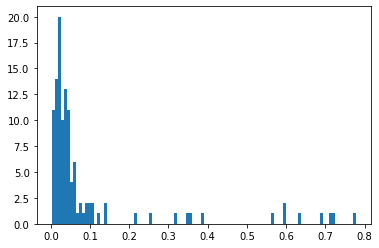

In [24]:
import numpy as np
import matplotlib.pyplot as plt
bi_scores = list()
for word1 in bigram_count.keys():
    for word2, prob in bigram_count[word1].items():
        bi_scores.append(prob)
# bi_scores = np.array(list(bigram_count.values()))
plt.hist(bi_scores, bins=100)
plt.show()

In [25]:
# new_lex = dict()
# for idx, (word, phone) in enumerate(lex.items()):
#     if idx > 4:
#         break
#     new_lex[word] = phone

# print(new_lex)

# from collections import defaultdict
# bigram_count = defaultdict(lambda:defaultdict(int))

# bigram_count_all = 0
# for file in glob.glob('/group/teaching/asr/labs/recordings/*.wav'):
#     transcript = read_transcription(file)
#     tmp_words = transcript.split()
#     tmp = [word not in list(new_lex.keys()) for word in tmp_words]
#     if sum(tmp) > 0:
#         continue
#     tmp_words = ["eps"] + tmp_words + ["eps"]
#     bigram_list = list(nltk.bigrams(tmp_words))
#     for bigram in bigram_list:
#         word1, word2 = bigram
#         bigram_count[word1][word2] += 1

# bigram_count = dict(bigram_count)
# for word1 in bigram_count.keys():
#     prob_sum = sum(bigram_count[word1].values())
#     for word2 in bigram_count[word1].keys():
#         bigram_count[word1][word2] /= prob_sum
# print(bigram_count)

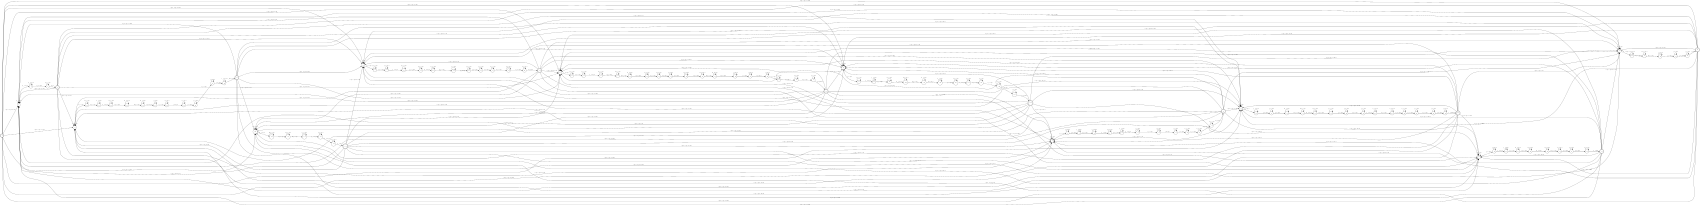

In [26]:
class BigramWfst:
    
    def __init__(self, n=3, lex=lex, self_loop_prob=None, final_prob_dict=None, bi_prob_dict=None):
        """
        Generate a HMM to recognise any single word sequence for words in the lexicon

        Args:
            n (int): states per phone HMM

        Returns:
            the constructed WFST

        """
        
        self.n = n
        self.lex = lex
        self.final_prob_dict = final_prob_dict
        self.self_loop_prob = self_loop_prob
        self.bi_prob_dict = bi_prob_dict
        self.f = self.generate_wfst()
    
    def generate_weighted_phone_wfst(self, f, start_state, phone, n, olabel):
        """
        Generate a weighted WFST representing an n-state left-to-right phone HMM.

        Args:
            f (fst.Fst()): an FST object, assumed to exist already
            start_state (int): the index of the first state, assumed to exist already
            phone (str): the phone label 
            n (int): number of states of the HMM excluding start and end

        Returns:
            the final state of the FST
        """
    

        current_state = start_state

        for i in range(1, n+1):
            if i == n:
                out = olabel
            else:
                out = 0

            in_label = state_table.find('{}_{}'.format(phone, i))

            prev_state = current_state
            current_state = f.add_state()
            if self.self_loop_prob == None:
                f.add_arc(prev_state, fst.Arc(in_label, 0, None, prev_state))
                f.add_arc(prev_state, fst.Arc(in_label, out, None, current_state))
            else:
                f.add_arc(prev_state, fst.Arc(in_label, 0, -math.log(self.self_loop_prob), prev_state))
                f.add_arc(prev_state, fst.Arc(in_label, out, -math.log(1-self.self_loop_prob), current_state))
        
        return current_state
    
    
    def generate_wfst(self):
        """
        """
        
        f = fst.Fst()

        # create a single start state
        start_state = f.add_state() # 0
        f.set_start(start_state)
        word_start_dict = dict()
        word_end_dict = dict()
        
        # =====================Bi-gram wfst====================
        for word, phones in self.lex.items():
            if word not in word_start_dict.keys():
                current_state = f.add_state()
                word_start_dict[word] = current_state
                for idx,phone in enumerate(phones):
                    if idx == len(phones)-1:
                            olabel = word_table.find(word)
                            current_state = self.generate_weighted_phone_wfst(f, current_state, phone, self.n, olabel)
                    else:
                        current_state = self.generate_weighted_phone_wfst(f, current_state, phone, self.n, 0)
                if self.final_prob_dict == None:
                    f.set_final(current_state)
                else:
                    f.set_final(current_state, -math.log(self.final_prob_dict[word]))
                word_end_dict[word] = current_state
            if word in self.bi_prob_dict["eps"].keys():
                current_start_state = word_start_dict[word]
                f.add_arc(start_state, fst.Arc(0, 0, -math.log(self.bi_prob_dict["eps"][word]), current_start_state))
                
            for word2, prob in self.bi_prob_dict[word].items():
                if word2 == "eps":
                    continue
                if word2 not in self.lex.keys():
                    continue
#                 if self.bi_prob_dict[word][word2] < 0.06:
#                     continue
                if word2 not in word_start_dict.keys():
                    current_state = f.add_state()
                    word_start_dict[word2] = current_state
                    phones = self.lex[word2]
                    for idx, phone in enumerate(phones):
                        if idx == len(phones)-1:
                            olabel = word_table.find(word2)
                            current_state = self.generate_weighted_phone_wfst(f, current_state, phone, self.n, olabel)
                        else:
                            current_state = self.generate_weighted_phone_wfst(f, current_state, phone, self.n, 0)
                    if self.final_prob_dict == None:
                        f.set_final(current_state)
                    else:
                        f.set_final(current_state, -math.log(self.final_prob_dict[word]))
                    word_end_dict[word2] = current_state
                f.add_arc(word_end_dict[word], fst.Arc(0, 0, -math.log(self.bi_prob_dict[word][word2]), word_start_dict[word2]))    
        
        f.set_input_symbols(state_table)
        f.set_output_symbols(word_table)
        
        return f

    
    def plot(self):
        """
        """
    
        # We need special code to display the higher-resolution WFSTs inside Jupyter notebook
        from subprocess import check_call
        from IPython.display import Image    
        self.f.draw('tmp.dot', portrait=True)
        check_call(['dot','-Tpng','-Gdpi=200','tmp.dot','-o','tmp.png'])
        return Image(filename='tmp.png')
    
BigramWfst(bi_prob_dict = bigram_count).plot()

In [ ]:
# create WFST and decoder
f = BigramWfst(bi_prob_dict=bigram_count).f
decoder = BaselineViterbiDecoder()

# create ASR
asr = ASR(f, decoder, CFG.audio_path, CFG.sample_num, verbose_all = CFG.verbose, verbose_result = CFG.verbose)

# save result in a dataframe
result_df_4_1 = pd.DataFrame(columns=["self-prob", "accuracy","num_arcs",
                                      "num_states","decode_time", "backtrace_time", "forward_cnt"])
tmp = pd.Series([None, asr.accuracy, asr.num_arcs, asr.num_states, 
                     asr.decode_time, asr.backtrace_time, asr.forward_cnt], index=result_df_4_1.columns, name=0)
result_df_4_1 = result_df_4_1.append(tmp)
if CFG.DEBUG == False:
    result_df_4_1.to_csv("task_4_bigram_df.csv",index=False)
result_df_4_1

### 2. Tree structured lexicon

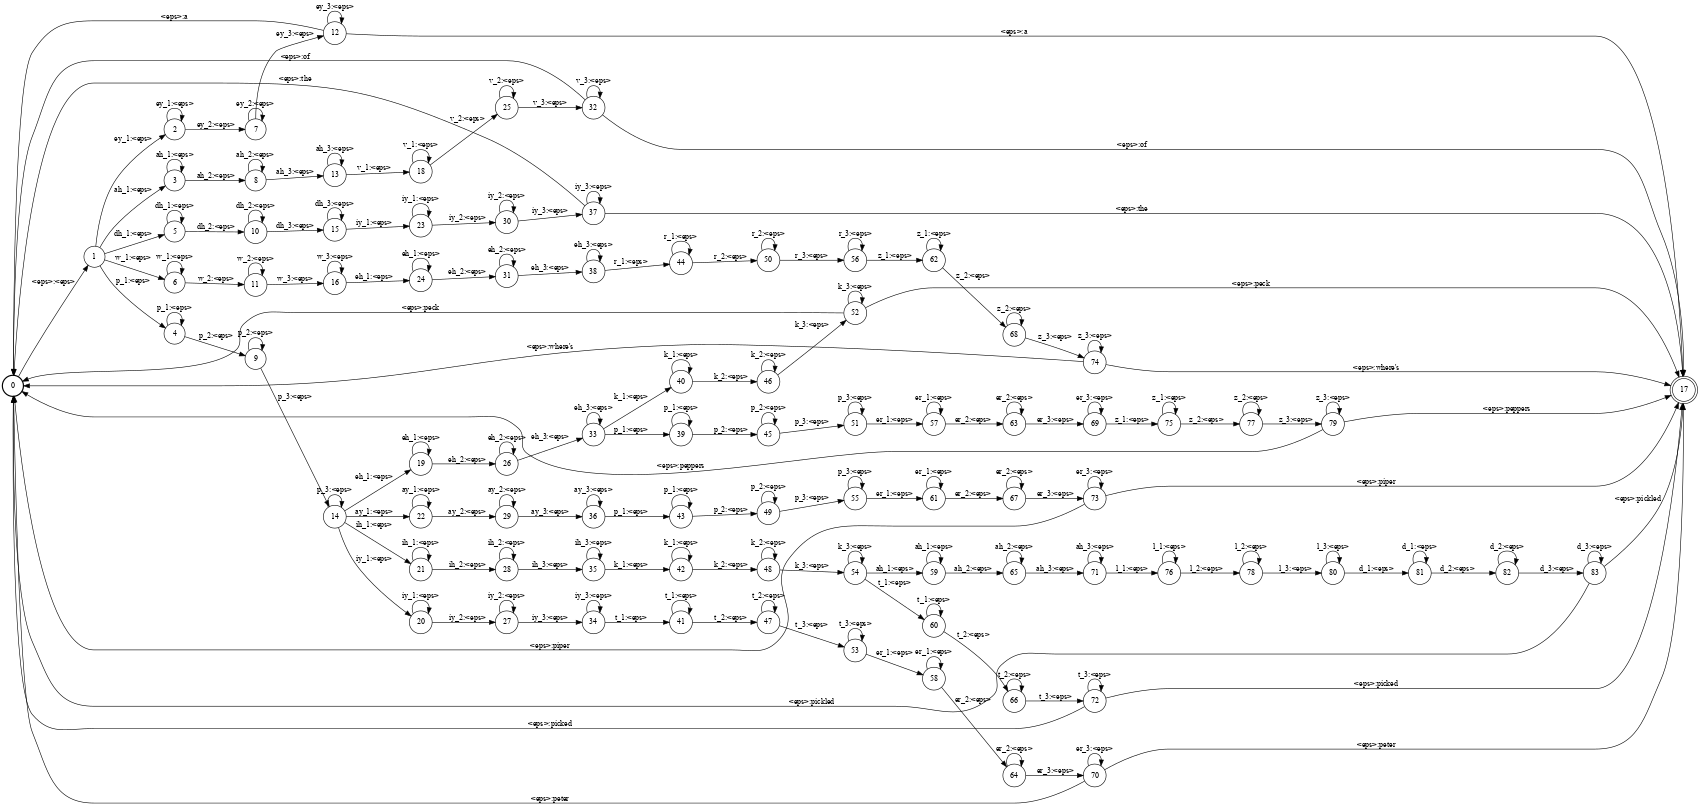

In [27]:
wfst = BaselineWfst()
f = fst.determinize(wfst.f)
wfst.f = f
wfst.plot()

In [28]:
# create WFST and decoder
f = fst.determinize(BaselineWfst().f)
decoder = BaselineViterbiDecoder()

# create ASR
asr = ASR(f, decoder, CFG.audio_path, CFG.sample_num, verbose_all = CFG.verbose, verbose_result = CFG.verbose)

# save result in a dataframe
result_df_4_2 = pd.DataFrame(columns=["self-prob", "accuracy","num_arcs",
                                      "num_states","decode_time", "backtrace_time", "forward_cnt"])
tmp = pd.Series([None, asr.accuracy, asr.num_arcs, asr.num_states, 
                     asr.decode_time, asr.backtrace_time, asr.forward_cnt], index=result_df_4_2.columns, name=0)
result_df_4_2 = result_df_4_2.append(tmp)
if CFG.DEBUG == False:
    result_df_4_2.to_csv("task_4_tree_lex_df.csv",index=False)
result_df_4_2

,self-prob,accuracy,num_arcs,num_states,decode_time,backtrace_time,forward_cnt
0,NaN,0.887683,183.0,84.0,4.519462,0.000951,81683.760563


### 3. Language model look-ahead 

In [ ]:
prev_word = 'piper'
f = fst.determinize(BaselineWfst().f)

LM = {prev_word: [0] * f.num_states() for prev_word in bigram_count.keys()}

print(bigram_count.keys())

traverse_states = list(f.states())
done_states = []

for state in f.states():
    if float(f.final(state)) == 0:
        final_state = state
        done_states.append(final_state)
        traverse_states.remove(final_state)
        
for state in traverse_states:
    for arc in f.arcs(state):
        if arc.nextstate == final_state:
            print(state)
            next_word = f.output_symbols().find(arc.olabel)
            for prev_word in LM.keys():
                LM[prev_word][state] = bigram_count[prev_word][next_word]
            traverse_states.remove(state)
            done_states.append(state)
            break
            
print()

while traverse_states:
#     print(traverse_states) 
    for state in traverse_states:
        if all([arc.nextstate in done_states + [state] for arc in f.arcs(state)]):
            print(state)
            for prev_word in LM.keys():
                LM[prev_word][state] = sum(LM[prev_word][arc.nextstate] for arc in f.arcs(state))
            traverse_states.remove(state)
            done_states.append(state)
# print(LM.items())
for word in bigram_count.keys():
    print(LM[word][0])

    
# print(LM[prev_word])




### 3.2 with language model pruning

### 4. Stack decoder (A* search)

In [ ]:
class AStarViterbiDecoder:
    
    NLL_ZERO = 1e10  # define a constant representing -log(0).  This is really infinite, but approximate
                     # it here with a very large number
    
    def __init__(self, f = None, audio_file_name = None):
        """Set up the decoder class with an audio file and WFST f
        """
        self.om = observation_model.ObservationModel()
        self.f = f
        self.audio_file_name = audio_file_name
        
        self.forward_cnt = 0

        
    def initialise_decoding(self):
        """set up the values for V_j(0) (as negative log-likelihoods)
        
        """
        # dynamic loading
        if self.audio_file_name:
            self.om.load_audio(self.audio_file_name)
        else:
            self.om.load_dummy_audio()
    
    
    
        self.forward_cnt = 0

        self.end = False
        self.Q = []
        heapq.heapify(self.Q)
    
        self.V = []   # stores likelihood along best path reaching state j
        self.B = []   # stores identity of best previous state reaching state j
        self.W = []   # stores output labels sequence along arc reaching j - this removes need for 
                      # extra code to read the output sequence along the best path
        
        for t in range(self.om.observation_length()+1):
            self.V.append([self.NLL_ZERO]*self.f.num_states())
            self.B.append([-1]*self.f.num_states())
            self.W.append([[] for i in range(self.f.num_states())])  #  multiplying the empty list doesn't make multiple
        
        # The above code means that self.V[t][j] for t = 0, ... T gives the Viterbi cost
        # of state j, time t (in negative log-likelihood form)
        # Initialising the costs to NLL_ZERO effectively means zero probability    
        
        # give the WFST start state a probability of 1.0   (NLL = 0.0)
        self.V[0][self.f.start()] = 0.0
        
        heapq.heappush(self.Q,(self.V[0][self.f.start()],0,self.f.start()))
        self.traverse = [(0,self.f.start())]
             
        
    def traverse_epsilon_arcs(self):
        """
        Traverse arcs with <eps> on the input at time t and state i
        
        These correspond to transitions that don't emit an observation
        
        """
        
        while self.traverse:
            
            # Set i to the ID of the current state, the first 
            # item in the list (and remove it from the list)
            t, i = self.traverse.pop(0)
            # don't bother traversing states which have zero probability
            if self.V[t][i] == self.NLL_ZERO:
                    continue
        
            for arc in self.f.arcs(i):
                
                if arc.ilabel == 0:     # if <eps> transition
                  
                    j = arc.nextstate   # ID of next state  
                
                    if self.V[t][j] > self.V[t][i] + float(arc.weight):
                        
                        # this means we've found a lower-cost path to
                        # state j at time t.  We might need to add it
                        # back to the processing queue.
                        self.V[t][j] = self.V[t][i] + float(arc.weight)
                        
                        # save backtrace information.  In the case of an epsilon transition, 
                        # we save the identity of the best state at t-1.  This means we may not
                        # be able to fully recover the best path, but to do otherwise would
                        # require a more complicated way of storing backtrace information
                        self.B[t][j] = self.B[t][i] 
                        
                        # and save the output labels encountered - this is a list, because
                        # there could be multiple output labels (in the case of <eps> arcs)
                        if arc.olabel != 0:
                            self.W[t][j] = self.W[t][i] + [arc.olabel]
                        else:
                            self.W[t][j] = self.W[t][i]
                        
                        if j not in self.traverse:
                            self.traverse.append((t,j))
                            
                        heapq.heappush(self.Q, (self.V[t][j],t,j))


    
    def forward_step(self, t, i):
                        
        if not self.V[t][i] == self.NLL_ZERO:   # no point in propagating states with zero probability
                        
            for arc in self.f.arcs(i):
                
                if arc.ilabel != 0: # <eps> transitions don't emit an observation
                    j = arc.nextstate
                    tp = float(arc.weight)  # transition prob
                    ep = -self.om.log_observation_probability(self.f.input_symbols().find(arc.ilabel), t+1)  # emission negative log prob
                    prob = tp + ep + self.V[t][i] # they're logs

                    self.forward_cnt += 1
                    
                    if prob < self.V[t+1][j]:
                        self.V[t+1][j] = prob
                        self.B[t+1][j] = i
    
                        # store the output labels encountered too
                        if arc.olabel !=0:
                            self.W[t+1][j] = [arc.olabel]
                        else:
                            self.W[t+1][j] = []
                                                
                        heapq.heappush(self.Q, (self.V[t+1][j],t+1,j))
                        self.traverse.append((t+1,j))

    
    def finalise_decoding(self):
        """ this incorporates the probability of terminating at each state
        """
        
        for state in self.f.states():
            final_weight = float(self.f.final(state))
            if self.V[-1][state] != self.NLL_ZERO:
                if final_weight == math.inf:
                    self.V[-1][state] = self.NLL_ZERO  # effectively says that we can't end in this state
                else:
                    self.V[-1][state] += final_weight          
        # get a list of all states where there was a path ending with non-zero probability
        finished = [x for x in self.V[-1] if x < self.NLL_ZERO]
        if not finished:  # if empty
            print("No path got to the end of the observations.")
            
            return False
            
            
        print(self.V[-1])
        
        return True
        
    def decode(self):
        
        self.initialise_decoding()
        while True:
            (v,t,i) = heapq.heappop(self.Q)
#             print(v,t,i)
            if t == self.om.observation_length() and self.finalise_decoding():
                print(v,t,i)
                print('break')
                break
            self.forward_step(t,i)
            self.traverse_epsilon_arcs()
        print('forward_cnt')
        print(self.forward_cnt)
    
    def backtrace(self):
        
        best_final_state = self.V[-1].index(min(self.V[-1])) # argmin
        best_state_sequence = [best_final_state]
        best_out_sequence = []
        
        t = self.om.observation_length()   # ie T
        j = best_final_state
        
        while t >= 0:
            i = self.B[t][j]
            best_state_sequence.append(i)
            best_out_sequence = self.W[t][j] + best_out_sequence  # computer scientists might like
                                                                                # to make this more efficient!

            # continue the backtrace at state i, time t-1
            j = i  
            t-=1
            
        best_state_sequence.reverse()
        
        # convert the best output sequence from FST integer labels into strings
        best_out_sequence = ' '.join([self.f.output_symbols().find(label) for label in best_out_sequence])
        
        return (best_state_sequence, best_out_sequence)





In [ ]:
# create WFST and decoder
f = BaselineWfst().f
decoder = AStarViterbiDecoder()

# create ASR
asr = ASR(f, decoder, CFG.audio_path, CFG.sample_num, verbose_all = CFG.verbose, verbose_result = CFG.verbose)

# save result in a dataframe
result_df_3_2 = pd.DataFrame(columns=["self-prob", "accuracy","num_arcs",
                                      "num_states","decode_time", "backtrace_time", "forward_cnt"])
tmp = pd.Series([None, asr.accuracy, asr.num_arcs, asr.num_states, 
                     asr.decode_time, asr.backtrace_time, asr.forward_cnt], index=result_df_3_2.columns, name=0)
result_df_3_2 = result_df_3_2.append(tmp)
if CFG.DEBUG == False:
    result_df_3_2.to_csv("task_3_A*_search_df.csv",index=False)
result_df_3_2